---
title: Automatic and optimal shift scheduling using Reinforcement Learning (Part 5)
subtitle: Using Sequential Decision Analytics to find ongoing optimal decisions
author: Kobus Esterhuysen
date: '2023-11-04'
date-modified: last-modified
categories:
  - Retail Industry
  - Scheduling
  - Powell Unified Framework
  - Reinforcement Learning
  - Python
image: AIShiftScheduler1.png
format:
  html:
    toc: true
    toc-depth: 4
    toc-expand: true
    toc-title: TOC
    code-fold: false
---

In [1]:
#- !pip install mojo

In [2]:
# hide
# BASED ON
  # AIShiftScheduler_KE^v11.ipynb
  # AIShiftScheduler_KE^v10.ipynb
  # AIShiftScheduler_KE^v9.ipynb
  # AIShiftScheduler_KE^v8.ipynb
  # AIShiftScheduler_KE^v7.ipynb
  # AIShiftScheduler_KE^v6.ipynb
  # AIShiftScheduler_KE^v5.ipynb
  # AIShiftScheduler_KE^v4.ipynb
  # AIShiftScheduler_KE^v3.ipynb
  # AIShiftScheduler_KE^v2.ipynb
  # AIShiftScheduler_KE^v1.ipynb
  # FractionalHR_KE^v1.ipynb
  # CarRental_KE^v4.ipynb
  # CarRental_KE^v3.ipynb
  # CarRental_KE^v2.ipynb
  # CarRental_KE^v1.ipynb
  # InventoryStorage_KE^v4.ipynb

# DONE
# v1 starts ------------------------------------------------
# added thHi (resources shifts below thHi considered for alloc)
# v2 starts ------------------------------------------------
# added Ucum for unallocated demands
# updated text
# v3 starts ------------------------------------------------
# published
# added DOW (day-of-week) availabilities
# v4 starts ------------------------------------------------
# published
# tracking Ucum by resource type in addition to overall/total
  # will inform what resource type to hire/fire
# changed avails to candidates
# changed thHi to thCumShifts
# having datetimes in addition to t values
  # https://www.youtube.com/watch?v=UFuo7EHI8zc
  # https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html
  # https://matplotlib.org/stable/api/dates_api.html
  # subtract dates give Timedelta; each step add a Timedelta
  # don't plot with datetime x-labels - too cluttered
# added thSickProb and compare with each resource's SICK_PROB for the month
  # resource's SICK_PROB for the month must be lower than thSickProb to
  # be a candidate
  # setup params by month for prob. of calling in sick for each resource
# v5 starts ------------------------------------------------
# published
# changed X__AllocBelow to X__Alloc
# having costs/contributions instead of excluding candidates below thCumShifts & thSickProb
  # agent exploits by having thCumShifts & thSickProb around max so
  #   that it can use the complete pool
  # Ccum_CumShifts = -(RCumShifts - RCapacity) //Capacity in # shifts/week
  # Ccum_SickProb = -SICK_PROB(R, month)
  # LATER: Ccum_Merits = MERITS(R) //merits dissipate over time; positive or negative merits
  # for thetas have the weights between
    # thCumShifts*Ccum_CumShifts + thSickProb*Ccum_SickProb + thMerits*Ccum_Merits = 100%
  # this way the whole (available) pool are candidates every step
# updated text
# v6 starts ------------------------------------------------
# published part 4
# added merits for resources [v]
  # MERITS pars with columns MeritProb, DemeritProb
  # RMerits_t in state vector
  # simulated similar to demands
  # add thMerits & Ccum_Merits
# renamed SIM to DEM
# created P.plot_Fhat_map_3()
# throwed out Shift1 & Shift2
# added thSelect (categorical; from candidates, list of resources to alloc) [v]
  # first ??
  # random
  # ranked (say perf scores)
# updated text
# v7 starts ------------------------------------------------
# published part 5
# changed availability value from True/False to 1/0 [v]
# added HOD (hour-of-day) availabilities [v]
# renamed CumShifts to CumSlots.
# added Ccum_ContSlots for contiguous slots
# added S_t['xAlloc_t_1'] sub-vector to S_t (previous allocations)
# v8 starts ------------------------------------------------
# added DOW+HOD availabilities [v]
# v9 starts ------------------------------------------------
# tuned with longer MAX_DAILY_SHIFT_LENGTH, currently 4hours/16quarters
# disabling parameters by setting them to constant instead of changing code
# reduced granularity from 1 hour to 15 mins [v]
# having a single shift/day/resource to reduce gaps [v]
# v10 starts ------------------------------------------------
# having flags for TRAIN/EVALU so that complete notebook can be run automatically [v]
  # MODES = [TRAIN, EVALU, APPLY] OR [LEARN, APPLY]
# anvil-enabled the notebook [v]
  # https://anvil.works/learn/tutorials/google-colab-to-web-app
  # capture procedure
# v11 starts ------------------------------------------------
# reading in AVAILABILITIES_DOW_QOD from excel [v]
  # did NOT use .gsheet google docs spreadsheet, instead use gdocs excel version
  # have resources on cols (fewer than the other)
  # DOW, QOD down the rows
# reading in SICK_PROBS and MERIT_PROBS from excel [v]
# v12 starts ------------------------------------------------
# tried to convert notebook to vscode & mojo
  # migrated to vscode dev container
  # not mature enough for now, but will keep working
# v13 starts ------------------------------------------------
# migrated to vscode dev container with github [v]
  # allows more formal path to production
  # can deploy container on DigitalOcean
# understanding relationship between devcontainer and prdcontainer [v]

# TODO
# investigate python parallelization [v]
  # g'best solutions to speedup python notebook training'
  # https://www.mineo.app/blog-page/top-strategies-for-optimising-python-notebooks
# investigate the use of mojo [v]
# externalize MAX_DAILY_SHIFT_LENGTH as user input [v]
# externalize TYPES with amounts as user input [v]
# track and use resource utilizations to compare againt gov incentive [v]
# have DemandSimulator depend on dt (DOY?, MOY?, DOW, QOD) [v]
  # read in from spreadsheet
# do cross-allocations, incurring cost [v]
# add all 4 resource types [v]
# add no-shows based on SICK_PROBS as exog info [v]
  # incur penalty for no-show
# consider learnability of pars in parameter cell [v]
# add demands for specific resources [v]
  # part of DemandSimulator
  # like Sally for first shift on Mon
  # only b attribute is the id of the resource

## 0 INTRODUCTION

In the previous part we found that the agent  exploited the situation by having `thCumShifts` and `thSickProb` near their max values so that it can use the complete pool. So, instead of using thresholds below which resources are included as candidates, we always had all (available) resources in the candidates pool. The agent earned rewards or incurred penalties to discourage allocation of less ideal resources. The had the parameters:

- $\theta^{CumShifts}$
- $\theta^{SickProb}$

Each of these operated as weighting factors to weigh the associated component of the cumulative reward $C^{cum}$:

$C^{cum} = \theta^{CumShifts}.C^{cum}_{CumShifts} + \theta^{SickProb}.C^{cum}_{SickProb}$

In this part we add one more weighting parameters so that we now have:

- $\theta^{CumShifts}$
- $\theta^{SickProb}$
- $\theta^{CumMerits}$

The cumulative reward is now calculated:
$C^{cum} = \theta^{CumShifts}.C^{cum}_{CumShifts} + \theta^{SickProb}.C^{cum}_{SickProb} + \theta^{CumMerits}.C^{cum}_{CumMerits}$

In addition, we add a fourth (categorical) parameter called $\theta^{Select}$ which can have one of two values:

- 'random'
- 'ranked_CumMerits'

Once the list of available candidates are identified this list is either randomized ('random'), or it is ranked by the resources' cumulative merits ('ranked_CumMerits').

To keep the visualizations manageable, we will still only have the resources:

- Courtesy Clerk (7 resources)
- Stocker (3 resources)

In a later part we will also add:

- Cleaner (2 resources)
- Curbsider (4 resources)

Daily demands are provided by a stochastic demand simulator based on past needs and trends. We also add a merit simulator.

The overall *structure* of this project and report follows the traditional CRISP-DM format. However, instead of the CRISP-DM'S "4 Modeling" section, we inserted the "6 step modeling process" of [Dr. Warren Powell](https://castlelab.princeton.edu/people/) in section 4 of this document. Dr Powell's universal framework shows great promise for unifying the formalisms of at least a dozen different fields. Using his framework enables easier access to thinking patterns in these other fields that might be beneficial and informative to the sequential decision problem at hand. Traditionally, this kind of problem would be approached from the *reinforcement learning* perspective. However, using Dr. Powell's wider and more comprehensive perspective almost certainly provides additional value.

Here is information on Dr. Powell's perspective on [Sequential Decision Analytics](https://castlelab.princeton.edu/sda).

In order to make a strong mapping between the code in this notebook and the mathematics in the Powell Universal Framework (PUF), we follow the following convention for naming Python identifier names:

- How to read/say
  - var name & flavor first
  - at t/n
  - for entity OR of/with attribute
  - $\hat{R}^{fail}_{t+1,a}$ has code `Rhat__fail_tt1_a` which is read: "Rhatfail at t+1 of/with (attribute) a"
- Superscripts
  - variable names have a *double* underscore to indicate a superscript
  - $X^{\pi}$: has code `X__pi`, is read *X pi*
  - when there is a 'natural' distinction between the variable symbol and the superscript (e.g. a change in case), the double underscore is sometimes omitted: `Xpi` instead of `X__pi`, or `MSpend_t` instead of `M__Spend_t`
- Subscripts
  - variable names have a *single* underscore to indicate a subscript
  - $S_t$: has code `S_t`, is read 'S at t'
  - $M^{Spend}_t$ has code `M__Spend_t` which is read: "MSpend at t"
  - $\hat{R}^{fail}_{t+1,a}$ has code `Rhat__fail_tt1_a` which is read: "Rhatfail at t+1 of/with (attribute) a" [RLSO-p436]
- Arguments
  - collection variable names may have argument information added
  - $X^{\pi}(S_t)$: has code `X__piIS_tI`, is read 'X pi in S at t'
  - the surrounding `I`'s are used to imitate the parentheses around the argument
- Next time/iteration
  - variable names that indicate one step in the future are quite common
  - $R_{t+1}$: has code `R_tt1`, is read 'R at t+1'
  - $R^{n+1}$: has code `R__nt1`, is read 'R at n+1'
- Rewards
  - State-independent terminal reward and cumulative reward
    - $F$: has code `F` for terminal reward
    - $\sum_{n}F$: has code `cumF` for cumulative reward
  - State-dependent terminal reward and cumulative reward
    - $C$: has code `C` for terminal reward
    - $\sum_{t}C$: has code `cumC` for cumulative reward
- Vectors where components use different names
  - $S_t(R_t, p_t)$: has code `S_t.R_t` and `S_t.p_t`, is read 'S at t in R at t, and, S at t in p at t'
  - the code implementation is by means of a named tuple
    - `self.State = namedtuple('State', SVarNames)` for the 'class' of the vector
    - `self.S_t` for the 'instance' of the vector
- Vectors where components reuse names
  - $x_t(x_{t,GB}, x_{t,BL})$: has code `x_t.x_t_GB` and `x_t.x_t_BL`, is read 'x at t in x at t for GB, and, x at t in x at t for BL'
  - the code implementation is by means of a named tuple
    - `self.Decision = namedtuple('Decision', xVarNames)` for the 'class' of the vector
    - `self.x_t` for the 'instance' of the vector
- Use of mixed-case variable names
  - to reduce confusion, sometimes the use of *mixed-case* variable names are preferred (even though it is not a best practice in the Python community), reserving the use of underscores and double underscores for math-related variables

## 1 BUSINESS UNDERSTANDING

The HR manager has to schedule resources for each day. This schedule will be automated and optimized by the AI agent.

The number of resources of each type for each schedule slots for each day will be provided by the simulator. Only two resource types will be handled:

- Courtesy
- Stocker

The HR manager typically runs the AI Shift Scheduler 2 weeks into the future to produce a tentative schedule to publish for the team.

As demands for shift slot allocations come in, they are handled in the following way:

- the candidates for the resource type must have their:
  - $R^{Avail}_t$ be True

- the specific resources are then marked for allocation considering the number of resources needed for the type
- the state of the resources are then updated including the number of accumulated shifts
- at the end of the shift all resources are made available again

The overall objective will be to maximize the cumulative reward.

## 2 DATA UNDERSTANDING

Based on recent market research, the demand may be modeled by a Poisson distribution for each resource type:
$$
\begin{aligned}
\mu^{ResourceType} &= \mathrm{SIM\_MU\_D[RESOURCE\_TYPE]}
\end{aligned}
$$

So we have:
$$
D^{ResourceType}_{t+1} \sim Pois(\mu^{ResourceType})
$$

For each decision window, a `MeritProb` and `DemeritProb` unique to each resource is used to simulate whether that resource earned a merit (+1) and/or demerit (-1). The two values are summed to get a net merit. These merit values are also accumulated.

The decision window is 1 day and these simulations are for the daily demands for Shift1.

In [3]:
# # #hide
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive"
# # base_dir = root_dir + '/Powell/SD.I_Inventory_Problems/InventoryStorage'
# base_dir = root_dir + '/Powell/SD.CRA_Complex_Resource_Allocation_Problems/Scheduling'

In [4]:
## import pdb
from collections import namedtuple, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy
import time
# from scipy.ndimage.interpolation import shift
# import pickle
# from bisect import bisect
import math
from pprint import pprint
import matplotlib as mpl
# from certifi.core import where
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
! python --version

Python 3.8.18


In [5]:
## hide
## def contribution(aName, bName):
#   a = aName.split('_')
#   b = bName.split('_')
#   if (
#     a[0] == b[0]:
#     bool(b[2]) == False and a[0] != b[0]) or \
#     (bool(b[2]) == True and mySubMatrix['_'.join([a[0], b[0]])] == False):
#     value = params['INFEASIABLE_SUBSTITUTION_PENALTY']
#   else:

In [6]:
base_dir = '.'
file_name = 'shift_scheduler_data.xlsx'

In [7]:
# !pip install openpyxl

In [8]:
def load_availabilities(filename):
  avail_df = pd.read_excel(
      filename,
      sheet_name='Availabilities',
      skiprows=3
      )
  return avail_df
AVAILABILITIES_DOW_QOD = load_availabilities(f'{base_dir}/{file_name}')

In [9]:
def load_sick_probs(filename):
  sick_df = pd.read_excel(
      filename,
      sheet_name='SickProbs',
      # skiprows=3,
      converters={'ResourceId':str}
      )
  return sick_df
SICK_PROBS = load_sick_probs(f'{base_dir}/{file_name}')

In [10]:
def load_merit_probs(filename):
  merit_df = pd.read_excel(
      filename,
      sheet_name='MeritProbs',
      # skiprows=3,
      converters={'ResourceId':str}
      )
  return merit_df
MERIT_PROBS = load_merit_probs(f'{base_dir}/{file_name}')

We will have the *learnable* parameters:

$$(\theta^{CumShifts}, \theta^{SickProb}, \theta^{CumMerits}, \theta^{Select})$$


In [11]:
## PARAMETERS
MODES = ['LEARN']
# MODES = ['TRAIN']
# MODES = ['TRAIN', 'EVALU']
# MODES = ['TRAIN', 'EVALU', 'APPLY']
# MODES = ['EVALU', 'APPLY']
# MODES = ['APPLY']
BEST_THETA_Alloc = (0, 0, 0, 1, 'random') #will be written/read eventually

## SNAMES = [ #state variable names
#     'RAvail_t', #available resource
#     'R_t',      #resource
#     'D_t',      #demand
# ]
## xNAMES = ['x_t'] #decision variable names

## TYPES = ['Courtesy']*7 + ['Stocker']*3 + ['Cleaner']*2 + ['Curbsider']*4
TYPES = ['Courtesy']*7 + ['Stocker']*3
print(f'\n{len(TYPES)=}')
print(TYPES)

RESOURCE_IDS = [str(i+1) for i in range(len(TYPES))]
## RESOURCE_TYPES = ['Courtesy', 'Stocker', 'Cleaner', 'Curbsider']
RESOURCE_TYPES = ['Courtesy', 'Stocker']
print(f'\n{len(RESOURCE_TYPES)=}')
print(RESOURCE_TYPES)

## *resource* attribute vectors
aNAMES = [tup[0]+'_'+tup[1] for tup in zip(RESOURCE_IDS, TYPES)]
print(f'{len(aNAMES)=}')
print(aNAMES)

## *demand* attribute vectors
bNAMES = RESOURCE_TYPES
print(f'\n{len(bNAMES)=}')
print(bNAMES)

## *decision* 'attribute' vectors
abNAMES = [] ##to DEMAND b
for a in aNAMES:
  a0,a1 = a.split('_')
  for b in bNAMES:
    if(a1==b):
      abn = (a + '___' + b)
      abNAMES.append(abn)
print(f'\n{len(abNAMES)=}')
print(abNAMES)

piNAMES = ['X__Alloc'] ##policy names
thNAMES = [ ##theta names
  'thCumSlots',
  'thSickProb',
  'thCumMerits',
  'thContSlots',
  'thSelect'
]
print(f'\n{len(thNAMES)=}')
print(f'{thNAMES=}')

def get_availabilities(dow, qod):
  avails = \
    AVAILABILITIES_DOW_QOD.loc[
      (AVAILABILITIES_DOW_QOD['DOW']==dow) & \
      (AVAILABILITIES_DOW_QOD['QOD']==qod),
      [e for e in AVAILABILITIES_DOW_QOD.columns if e in RESOURCE_IDS]
    ].iloc[0]
    #- ].iloc[0].reset_index(drop=True, inplace=True)
  avails.reset_index(drop=True, inplace=True) ##to start index at 0
  return avails

def get_capacities(dow):
  capacities = \
    AVAILABILITIES_DOW_QOD.loc[
      (AVAILABILITIES_DOW_QOD['DOW']==dow),
      [e for e in AVAILABILITIES_DOW_QOD.columns if e in RESOURCE_IDS]
    ].sum(axis=0) ##total daily capacity
  capacities.reset_index(drop=True, inplace=True)
  return capacities

SEED_TRAIN = 77777777
SEED_EVALU = 88888888
## N_SAMPLEPATHS = 100; L = N_SAMPLEPATHS
## N_TRANSITIONS = 100; T = N_TRANSITIONS

TH_CumSlots_SPEC = (0, 1, .2)
TH_SickProb_SPEC = (0, 1, .2)
TH_CumMerits_SPEC = (0, 1, .2)
TH_ContSlots_SPEC = (0, 1, .2)
TH_Select_SPEC = ('random', 'ranked_CumMerits')
## TH_Select_SPEC = ('ranked_CumMerits',)

SIM_T = 60
SIM_MU_D = {bNAMES[0]: 4, bNAMES[1]: 2}
print(f'\n{SIM_MU_D=}')
assert len(SIM_MU_D.items())==len(bNAMES)

## SIM_EVENT_TIME_D = {bNAMES[0]: None, bNAMES[1]: None, bNAMES[2]: None, bNAMES[3]: None}
SIM_EVENT_TIME_D = {bNAMES[0]: None, bNAMES[1]: None}
print(f'\n{SIM_EVENT_TIME_D=}')
assert len(SIM_EVENT_TIME_D.items())==len(bNAMES)

## SIM_MU_DELTA_D = {bNAMES[0]: None, bNAMES[1]: None, bNAMES[2]: None, bNAMES[3]: None}
SIM_MU_DELTA_D = {bNAMES[0]: None, bNAMES[1]: None}
print(f'\n{SIM_MU_DELTA_D=}')
assert len(SIM_MU_DELTA_D.items())==len(bNAMES)

START_DATE_TIME = '2023-10-30'
sd = pd.to_datetime(START_DATE_TIME)
assert sd.strftime('%a')=='Mon'
DATE_TIME_DELTA = '15min' ##also '1D', '1H', etc

MAX_DAILY_SHIFT_LENGTH = 8*4 ## 32 quarters or 8 hours
CONTIGUOUS_REWARD = 10

GOV_UTIL_THESH = 0.40

## math parameters use 'math/small case' (as opposed to code parameters):

## CONTRIB_MATRIX = {}
# for an in aNAMES:
#     contribs = {}
#     for bn in bNAMES:
#       contribs[bn] = contribution(an, bn)
#     CONTRIB_MATRIX[an] = contribs
# CONTRIB_MATRIX


len(TYPES)=10
['Courtesy', 'Courtesy', 'Courtesy', 'Courtesy', 'Courtesy', 'Courtesy', 'Courtesy', 'Stocker', 'Stocker', 'Stocker']

len(RESOURCE_TYPES)=2
['Courtesy', 'Stocker']
len(aNAMES)=10
['1_Courtesy', '2_Courtesy', '3_Courtesy', '4_Courtesy', '5_Courtesy', '6_Courtesy', '7_Courtesy', '8_Stocker', '9_Stocker', '10_Stocker']

len(bNAMES)=2
['Courtesy', 'Stocker']

len(abNAMES)=10
['1_Courtesy___Courtesy', '2_Courtesy___Courtesy', '3_Courtesy___Courtesy', '4_Courtesy___Courtesy', '5_Courtesy___Courtesy', '6_Courtesy___Courtesy', '7_Courtesy___Courtesy', '8_Stocker___Stocker', '9_Stocker___Stocker', '10_Stocker___Stocker']

len(thNAMES)=5
thNAMES=['thCumSlots', 'thSickProb', 'thCumMerits', 'thContSlots', 'thSelect']

SIM_MU_D={'Courtesy': 4, 'Stocker': 2}

SIM_EVENT_TIME_D={'Courtesy': None, 'Stocker': None}

SIM_MU_DELTA_D={'Courtesy': None, 'Stocker': None}


In [12]:
## for deployment
# MODES = ['APPLY', 'LEARN']
if 'APPLY' in MODES:
  !pip install anvil-uplink

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [13]:
## for deployment
if 'APPLY' in MODES:
  import anvil.server
  anvil.server.connect("")

Connecting to wss://anvil.works/uplink


Anvil websocket open
Connected to "Debug for kobus78@gmail.com" as SERVER


In [14]:
class DemandSimulator():
  def __init__(self,
    T__sim=SIM_T,
    muD=SIM_MU_D,
    eventTimeD=SIM_EVENT_TIME_D,
    muDeltaD=SIM_MU_DELTA_D,
    seed=None):
    self.time = 0
    self.T__sim = SIM_T
    self.muD = SIM_MU_D
    self.eventTimeD = SIM_EVENT_TIME_D
    self.muDeltaD = SIM_MU_DELTA_D
    self.prng = np.random.RandomState(seed)

  def simulate(self):
    if self.time > self.T__sim - 1:
      self.time = 0
    D_tt1 = {}
    for bn in bNAMES:
      if self.eventTimeD[bn] and self.time > self.eventTimeD[bn]: #event for entity
        D_tt1[bn] = self.muDeltaD[bn] + self.prng.poisson(self.muD[bn]) #after event
      else:
        D_tt1[bn] = self.prng.poisson(self.muD[bn])
    self.time += 1
    return {bn: max(0, D_tt1[bn]) for bn in bNAMES} #always positive

In [15]:
dem_sim = DemandSimulator(seed=1234)
DemandData = []
for i in range(SIM_T):
  d = list(dem_sim.simulate().values())
  DemandData.append(d)
labels = [f'{bn}_dem' for bn in bNAMES]
df = pd.DataFrame.from_records(data=DemandData, columns=labels); df[:10]

,Courtesy_dem,Stocker_dem
0,5,4
1,6,4
2,6,3
3,6,1
4,3,2
5,3,6
6,4,2
7,4,2
8,1,1
9,7,1


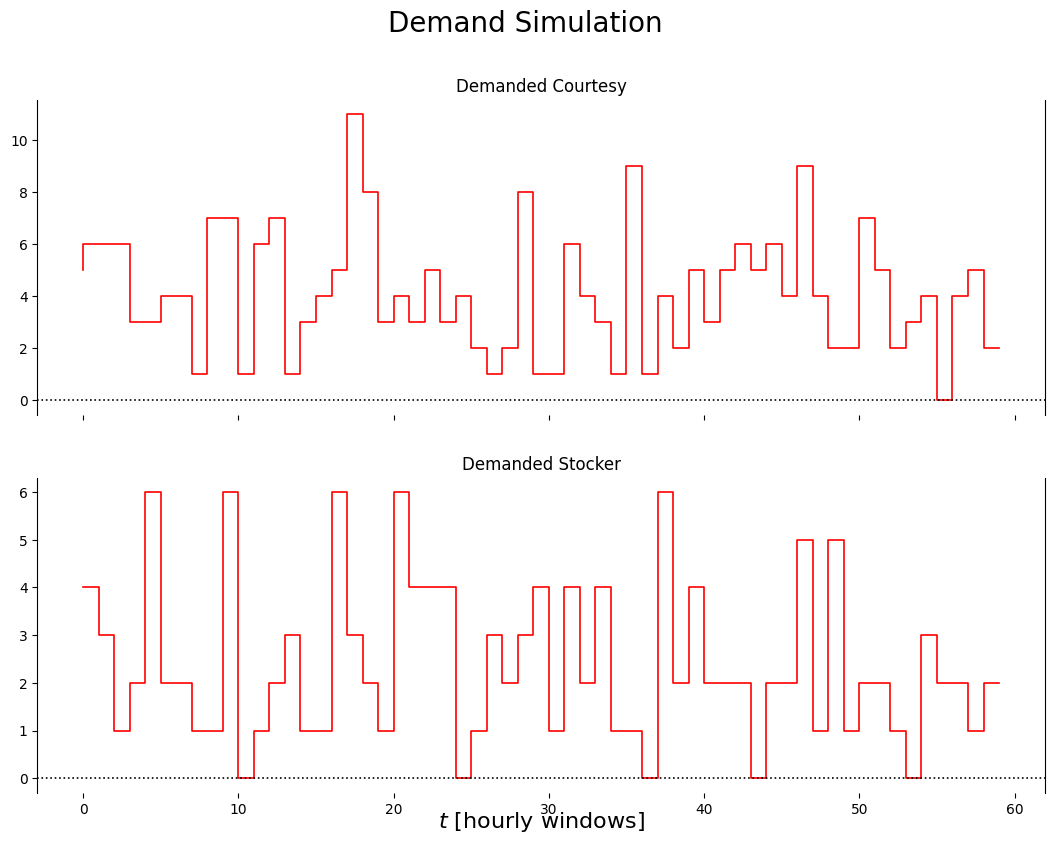

In [16]:
## PUT BACK: COMMENTED OUT TO BE FASTER
import random
def plot_output(df1, df2):
  n_charts = len(bNAMES)
  ylabelsize = 16
  mpl.rcParams['lines.linewidth'] = 1.2
  default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  fig, axs = plt.subplots(n_charts, sharex=True)
  fig.set_figwidth(13); fig.set_figheight(9)
  fig.suptitle('Demand Simulation', fontsize=20)

  for i,bn in enumerate(bNAMES):
    axs[i].set_title(f'Demanded {bn}')
    axs[i].set_ylim(auto=True); axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(True); axs[i].spines['bottom'].set_visible(False)
    axs[i].step(df1[f'{bn}_dem'], 'r-')
    ## axs[i].axhline(y=dem_sim.muD[e], color='k', linestyle=':')
    axs[i].axhline(y=0, color='k', linestyle=':')

  axs[i].set_xlabel('$t\ \mathrm{[hourly\ windows]}$', rotation=0, ha='center', va='center', fontweight='bold', size=ylabelsize)
plot_output(df, None)

In [17]:
class MeritSimulator():
  def __init__(self, seed=None):
    self.prng = np.random.RandomState(seed)

  def simulate(self):
    M_tt1 = {}
    for an in aNAMES:
      resourceId,_ = an.split('_')
      a,b = MERIT_PROBS.loc[
        MERIT_PROBS['ResourceId'] == resourceId,
        ['MeritProb', 'DemeritProb']
      ].values[0]
      if np.random.uniform() < a: merit = 1
      else: merit = 0
      if np.random.uniform() < b: demerit = 1
      else: demerit = 0
      M_tt1[an] = merit - demerit ##net merit
    return M_tt1

In [18]:
mer_sim = MeritSimulator(seed=1234)
MeritData = []
for i in range(100):
  mer = list(mer_sim.simulate().values())
  MeritData.append(mer)
labels = [f'{an}_merit' for an in aNAMES]
df = pd.DataFrame.from_records(data=MeritData, columns=labels); df[:10]

,1_Courtesy_merit,2_Courtesy_merit,3_Courtesy_merit,4_Courtesy_merit,5_Courtesy_merit,6_Courtesy_merit,7_Courtesy_merit,8_Stocker_merit,9_Stocker_merit,10_Stocker_merit
0,0,0,1,0,-1,0,1,0,0,0
1,0,0,0,0,0,1,0,-1,1,0
2,0,0,0,0,0,0,0,0,-1,0
3,0,1,0,-1,0,1,0,1,0,0
4,0,0,0,0,0,0,0,-1,0,0
5,0,0,0,0,0,1,0,-1,0,1
6,-1,1,1,0,0,0,0,0,0,0
7,0,0,0,0,0,1,0,-1,1,0
8,0,0,0,0,0,0,1,0,1,0
9,0,0,0,0,0,0,0,-1,1,0


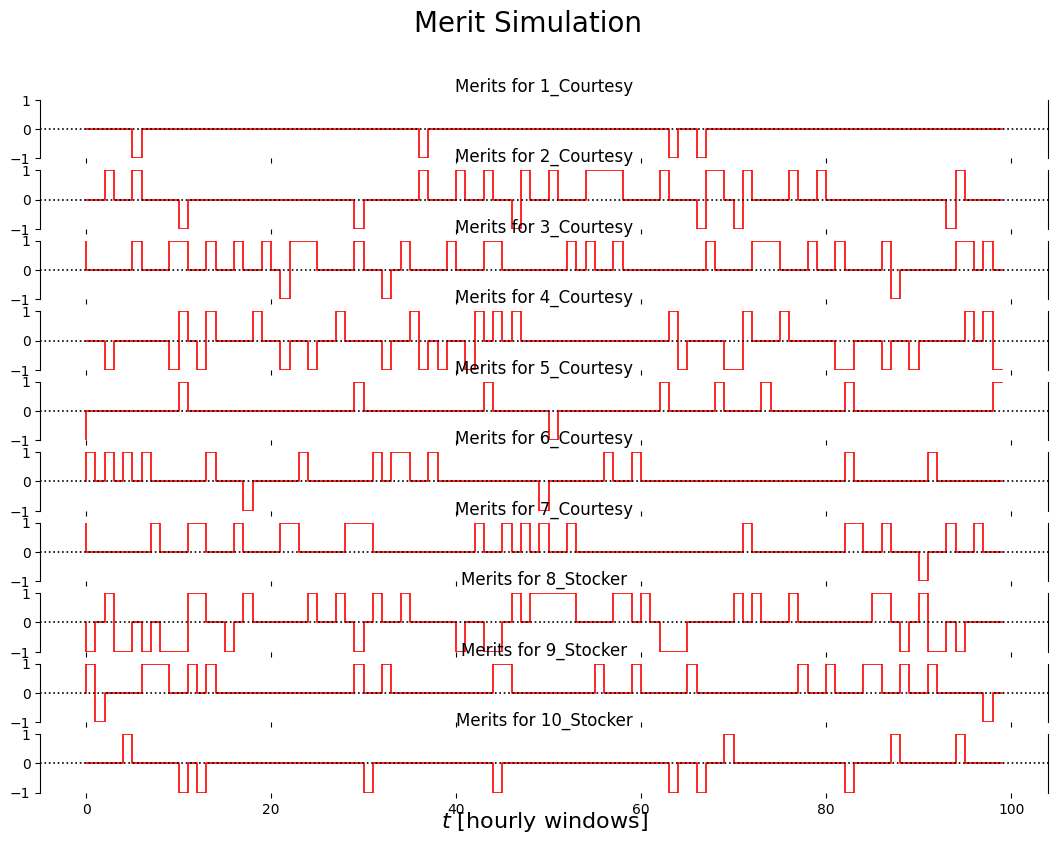

In [19]:
## PUT BACK: COMMENTED OUT TO BE FASTER
import random
def plot_output(df1, df2):
  n_charts = len(aNAMES)
  ylabelsize = 16
  mpl.rcParams['lines.linewidth'] = 1.2
  default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  fig, axs = plt.subplots(n_charts, sharex=True)
  fig.set_figwidth(13); fig.set_figheight(9)
  fig.suptitle('Merit Simulation', fontsize=20)

  for i,an in enumerate(aNAMES):
    axs[i].set_title(f'Merits for {an}')
    axs[i].set_ylim(-1, 1); axs[i].spines['top'].set_visible(False); axs[i].spines['right'].set_visible(True); axs[i].spines['bottom'].set_visible(False)
    axs[i].step(df1[f'{an}_merit'], 'r-')
    ## axs[i].axhline(y=dem_sim.muD[e], color='k', linestyle=':')
    axs[i].axhline(y=0, color='k', linestyle=':')
  axs[i].set_xlabel('$t\ \mathrm{[hourly\ windows]}$', rotation=0, ha='center', va='center', fontweight='bold', size=ylabelsize)
plot_output(df, None)

## 3 DATA PREPARATION

We will use the data provided by the simulator directly. There is no need to perform additional data preparation.

## 4 MODELING

### 4.1 Narrative

Please review the narrative in section 1. The next figure is a representation of the solution to the problem:

![AIShiftScheduler1](AIShiftScheduler1.png)

### 4.2 Core Elements

This section attempts to answer three important questions:

- What metrics are we going to track?
- What decisions do we intend to make?
- What are the sources of uncertainty?

For this problem, the only metric we are interested in is the cumulative reward after each horizon. The only source of uncertainty is the levels of demand and the merits/demerits for each of the resource types.


### 4.3 Mathematical Model | SUS Design

A Python class is used to implement the model for the SUS (System Under Steer):

```
class Model():
  def __init__(self, S_0_info):
    ...
    ...
```

#### 4.3.1 State variables

The *state variables* represent *what we need to know*.

- $R^{Avail}_t = (R^{Avail}_{ta})_{a \in \cal A}$ where $\cal{A} = \{\alpha_1, \alpha_2, ... \alpha_{10}\}$
  - $R^{Avail}_{ta}$ = Boolean indicator for whether this resource (with attribute $a$), is available at $t$ for rental
  - $\alpha_1$ = 1_Courtesy
  - $\alpha_2$ = 2_Courtesy
  - $\alpha_3$ = 3_Courtesy
  - ...
  - $\alpha_{15}$ = 9_Stocker
  - $\alpha_{16}$ = 10_Stocker
- $R^{CumShifts}_t = (R^{CumShifts}_{ta})_{a \in \cal A}$ where $\cal{A} = \{\alpha_1, \alpha_2, ... \alpha_{10}\}$
  - $R^{CumShifts}_{ta}$ = Number of shifts this resource (with attribute $a$), has worked at $t$
  - $\alpha_1$ = 1_Courtesy
  - $\alpha_2$ = 2_Courtesy
  - $\alpha_3$ = 3_Courtesy
  - ...
  - $\alpha_{15}$ = 9_Stocker
  - $\alpha_{16}$ = 10_Stocker
- $R^{CumMerits}_t = (R^{CumMerits}_{ta})_{a \in \cal A}$ where $\cal{A} = \{\alpha_1, \alpha_2, ... \alpha_{10}\}$
  - $R^{CumMerits}_{ta}$ = Number of net merits this resource (with attribute $a$), has gained at $t$
  - $\alpha_1$ = 1_Courtesy
  - $\alpha_2$ = 2_Courtesy
  - $\alpha_3$ = 3_Courtesy
  - ...
  - $\alpha_{15}$ = 9_Stocker
  - $\alpha_{16}$ = 10_Stocker  
- $D^{Shift}_t = (D^{Shift}_{tb})_{b \in \cal B}$ where $\cal{B} = \{\beta_1, \beta_2\}$
  - $D^{Shift}_{tb}$ = Number of demands for this resource (with attribute $b$), at $t$
  - $\beta_1$ = Courtesy
  - $\beta_1$ = Stocker
- $n^{Merits}_t = (n^{Merits}_{tb})_{b \in \cal B}$ where $\cal{B} = \{\beta_1, \beta_2\}$
  - $n^{Merits}_{tb}$ = Number of merits for this resource (with attribute $b$), at $t$
  - $\beta_1$ = Courtesy
  - $\beta_1$ = Stocker  

The state is:

$$
\begin{aligned}
S_t &= (R^{Avail}_t, R^{CumShifts}_t, R^{CumMerits}_t, D^{Shift}_t, n^{Merits}_t)
\end{aligned}
$$

#### 4.3.2 Decision variables

The *decision variables* represent *what we control*.

The decision vector is given by:

- $x_t = (x_{tab})_{a\in \cal A, b\in \cal B}$ where
  - $\cal{A} = \{\alpha_1, \alpha_2, ... \alpha_{10}\}$
  - $\cal{B} = \{\beta_1, \beta_2\}$
  - $x_{tab}$ is a boolean vector that indicates whether a specific resource is to be allocated to a demand

- Decisions are made with a policy (TBD below):
  - $X^{\pi}(S_t)$

#### 4.3.3 Exogenous information variables


The *exogenous information variables* represent *what we did not know (when we made a decision)*. These are the variables that we cannot control directly. The information in these variables become available *after* we make the decision $x_t$.

When we assume that the demand in each time period is revealed, without any model to predict the demand based on past demands, we have, using approach 1:

$$
\begin{aligned}
D_{t+1} &= W_{t+1} \\
        &= \hat{D}_{t+1}
\end{aligned}         
$$

Alternatively, when we assume that we observe the *change* in demand $\hat{D}_{t+1}=p_{t+1}-p_{t}$, we have, using approach 2:

$$
\begin{aligned}
D_{t+1} &= D_t + W_{t+1} \\
        &= D_t + \hat{D}_{t+1}
\end{aligned}
$$

We will make use of approach 1 which means that the exogenous information, $W_{t+1}$, is the directly observed demands of the resources.

Similarly, for the earned merits, we have

$$
\begin{aligned}
n_{t+1} &= W_{t+1} \\
        &= \hat{n}_{t+1}
\end{aligned}         
$$

The exogenous information is obtained by calls to

`DemandSimulator.simulate(...)`

`MeritSimulator.simulate(...)`

#### 4.3.4 Transition function

The *transition function* describe how the state variables evolve over time. We have the equations:

$$
R^{Avail}_{t+1} =
\begin{cases}
  1 & \text{if resource with attribute $a$ has not been allocated} \\
  0 & \text{if resource with attribute $a$ has been allocated  }
\end{cases}
$$

$$
R^{CumShifts}_{t+1} =
\begin{cases}
  R^{CumShifts}_{t} + 1 & \text{if resource was allocated} \\
  R^{CumShifts}_{t} & \text{if resource was not allocated  }
\end{cases}
$$

$$
R^{CumMerits}_{t+1} = R^{CumMerits}_{t} + n^{Merits}_t
$$

Collectively, they represent the general transition function:

$$
S_{t+1} = S^M(S_t,X^{\pi}(S_t))
$$

#### 4.3.5 Objective function

The *objective function* captures the performance metrics of the solution to the problem.

We can write the state-dependant reward (also called contribution due to the allocation of a resource with attribute $b$):

$$
C(S_t,x_t) =
\begin{cases}
  1 & \text{if resource was allocated} \\
  -1 & \text{if resource was not allocated  }
\end{cases}
$$

We have the objective function:

$$
\max_{\pi}\mathbb{E}\{\sum_{t=0}^{T}C(S_t,x_t,W_{t+1}) \}
$$

The learned parameters are:

$$(\theta^{CumShifts}, \theta^{SickProb}, \theta^{CumMerits}, \theta^{Select})$$

#### 4.3.6 Implementation of the System Under Steer (SUS) Model

In [20]:
class Model():
  def __init__(self, W_fn=None, S__M_fn=None, C_fn=None):
    self.S_t = {
      'R_t': pd.DataFrame({
        'ResourceId': RESOURCE_IDS,
        'Type': TYPES,
        'RAvail_t': get_availabilities(dow=0, qod=0),
        'RCumSlots_t': [0]*len(TYPES), ##cumulative allocs (for T)
        # /////////////////////
        ## 'RMonthCumSlots_t': [0]*len(TYPES),
        ## 'RWeekCumSlots_t': [0]*len(TYPES),
        ## 'RUtil_t': [0]*len(TYPES),
        # \\\\\\\\\
        'RCumMerits_t': [0]*len(TYPES),
        'RComplete_t': [0]*len(TYPES), ## 1/0: daily shift complete or not
      }),
      'D_t': pd.DataFrame({
        'Type': RESOURCE_TYPES,
        'DSlot_t': [1]*len(RESOURCE_TYPES),
      }),
      'M_t': pd.DataFrame({
        'ResourceId': RESOURCE_IDS,
        'Type': TYPES,
        'nMerits_t': [0]*len(TYPES),
      }),
      'xAlloc_t_1': pd.DataFrame({ ##previous allocation
        'Comb': abNAMES, ##Combination
        'Allocd_t': [False]*len(abNAMES), ##Allocated
      }),
    }
    self.x_t = {
      'xAlloc_t': pd.DataFrame({
        'Comb': abNAMES, ##Combination
        'Allocd_t': [False]*len(abNAMES), ##Allocated
      }),
    }
    self.Ccum_CumSlots = 0.0
    self.Ccum_SickProb = 0.0
    self.Ccum_CumMerits = 0.0
    self.Ccum_ContSlots = 0.0
    self.Ccum = 0.0 ##cumulative reward

    self.Ucum_Total = 0 ##cumulative unallocated/unmet demands
    ##cumulative unallocated/unmet demands
    self.Ucum = {rt: 0 for rt in RESOURCE_TYPES}

  ## def reset(self):
  #   self.Ccum = 0.0
  #   self.Ucum = 0

  ## exogenous information, dependent on a random process,
  ## the directly observed demands
  def W_fn(self, t):
    return {
      ## 'demands': DEM.simulate(),
      'demands': {'Courtesy': 2, 'Stocker': 1},
      'merits': MER.simulate(),
    }

  def update_Ccum(self, t, dt, S_t, x_t, theta):
    ## dow, hod = ((t + 1)//24)%7, (t + 1)%24; ##print(f'{dow=}, {hod=}')
    dow, qod = ((t + 1)//96)%7, (t + 1)%96; ##print(f'{dow=}, {qod=}')
    m1 = \
      x_t['xAlloc_t'].merge(
      S_t['R_t']\
       [['RCumSlots_t', 'RAvail_t', 'RCumMerits_t']],
       left_index=True, right_index=True)

    ## merge in previous allocations
    m1a = \
      S_t['xAlloc_t_1'].merge(
      m1[['Allocd_t', 'RCumSlots_t', 'RAvail_t', 'RCumMerits_t']],
      left_index=True, right_index=True)
    m1a.rename(columns={'Allocd_t_x': 'Allocd_t_1', 'Allocd_t_y': 'Allocd_t'}, inplace=True)

    m2 = \
      m1a.merge(
      SICK_PROBS[[dt.month_name()]],
      left_index=True, right_index=True)
    m2.rename(columns={dt.month_name(): 'SickProb'}, inplace=True)

    m2['Capacity'] = pd.DataFrame({'Capacity': get_capacities(4)})
    m2['Ccum_CumSlots'] = -(m2['RCumSlots_t'] - m2['Capacity'])

    ## m2['Ccum_SickProb'] = -100*m2['SickProb']
    ## m2['Ccum_SickProb'] = -100*(m2['SickProb'] - m2['SickProb'].mean()) ##100 makes values more comparable with other component of Ccum
    m2['Ccum_SickProb'] = -1*(m2['SickProb'] - m2['SickProb'].mean()) ##100 makes values more comparable with other component of Ccum

    m2['Ccum_CumMerits'] = m2['RCumMerits_t']

    m2.loc[ ## contiguous slots
      (m2['Allocd_t'] == True) & \
      (m2['Allocd_t'] == m2['Allocd_t_1']),
      ['Ccum_ContSlots']
    ] = CONTIGUOUS_REWARD ## reward if shift is continued without interuption

    summables = m2.loc[
      m2['Allocd_t'] == True,
      ['Ccum_CumSlots', 'Ccum_SickProb', 'Ccum_CumMerits', 'Ccum_ContSlots'],
    ]
    Ccum_CumSlots, Ccum_SickProb, Ccum_CumMerits, Ccum_ContSlots = summables.sum(axis=0)
    Ccum = \
      theta.thCumSlots*Ccum_CumSlots + \
      theta.thSickProb*Ccum_SickProb + \
      theta.thCumMerits*Ccum_CumMerits + \
      theta.thContSlots*Ccum_ContSlots
    self.Ccum_CumSlots += Ccum_CumSlots
    self.Ccum_SickProb += Ccum_SickProb
    self.Ccum_CumMerits += Ccum_CumMerits
    self.Ccum_ContSlots += Ccum_ContSlots
    self.Ccum += Ccum

  def performAllocDecision(self, S_t, x_t, theta):
    ## find list of ResourceIds for allocs from x_t
    resourceIds = x_t['xAlloc_t'].loc[
      x_t['xAlloc_t']['Allocd_t']==True,
      ['Comb']
    ]['Comb'].str.split('_').str[:1].tolist(); ##print(f'{resourceIds=}')
    resourceIds_flat = [e[0] for e in resourceIds]; ##print(f'{resourceIds_flat=}')

    ## update state of allocs
    S_t['R_t'].loc[
      S_t['R_t']['ResourceId'].isin(resourceIds_flat),
      ['RAvail_t']
    ] = 0
    S_t['R_t'].loc[
      S_t['R_t']['ResourceId'].isin(resourceIds_flat),
      ['RCumSlots_t']
    ] += 1

    ## update Ccum with allocations
    ## self.Ccum += len(resourceIds_flat) #number of allocations

  def S__M_fn(self, t, dt, S_t, x_t, W_tt1, theta):
    ## dow, hod = ((t + 1)//24)%7, (t + 1)%24; ##print(f'{dow=}, {hod=}')
    dow, qod = ((t + 1)//96)%7, (t + 1)%96; ##print(f'{dow=}, {qod=}')

    ## perform decision taken this morning
    self.performAllocDecision(S_t, x_t, theta)

    ## D_t #direct approach
    for rt in RESOURCE_TYPES:
      sh_demands = W_tt1['demands'][rt]
      S_t['D_t'].loc[S_t['D_t']['Type']==rt, 'DSlot_t'] = sh_demands
    for an in aNAMES:
      resId = an.split('_')[0]
      merits = W_tt1['merits'][an]
      S_t['M_t'].loc[S_t['M_t']['ResourceId'] == resId, 'nMerits_t'] = merits

    ## Update cumulative merits of all resources
    S_t['R_t']['RCumMerits_t'] += S_t['M_t']['nMerits_t']

    ## Update availabilities of all resources
    S_t['R_t']['RAvail_t'] = get_availabilities(dow=dow, qod=qod)

    ## Update RComplete_t
    m1 = \
      S_t['xAlloc_t_1'].merge(
      x_t['xAlloc_t'],
      left_index=True, right_index=True)
    m1.rename(columns={'Comb_x': 'Comb', 'Allocd_t_x': 'Allocd_t_1', 'Allocd_t_y': 'Allocd_t'}, inplace=True)
    m1.drop('Comb_y', inplace=True, axis=1)
    m2 = m1.loc[(m1['Allocd_t_1'] == True) & (m1['Allocd_t'] == False)]
    resourceIds = m2.loc[
      (m2['Allocd_t_1'] == True) & (m2['Allocd_t'] == False),
      ['Comb']
    ]['Comb'].str.split('_').str[:1].tolist(); ##print(f'{resourceIds=}')
    resourceIds_flat = [e[0] for e in resourceIds]; ##print(f'{resourceIds_flat=}')
    S_t['R_t'].loc[
      S_t['R_t']['ResourceId'].isin(resourceIds_flat),
      ['RComplete_t']
    ] = 1

    ## Update 'xAlloc_t_1'
    S_t['xAlloc_t_1'] = copy(x_t['xAlloc_t']) ## SG

    # ## Reset for new month
    # if dt.is_month_start:
    #   S_t['R_t']['RMonthCumSlots_t'] = 0

    # ## Reset for new week
    # if dow == 0:
    #   S_t['R_t']['RMonthCumSlots_t'] += S_t['R_t']['RWeekCumSlots_t']
    #   S_t['R_t']['RWeekCumSlots_t'] = 0

    ## Reset for new day
    if qod == 0:
      S_t['R_t']['RCumSlots_t'] = 0; ##print(f'%%% Resetting RCumSlots_t ...')
      ## S_t['R_t']['RWeekCumSlots_t'] += S_t['R_t']['RCumSlots_t']
      ## S_t['R_t']['RCumSlots_t'] = 0; ##print(f'%%% Resetting RCumSlots_t ...')

      S_t['R_t']['RComplete_t'] = 0
      self.Ucum = {rt: 0 for rt in RESOURCE_TYPES}
      self.Ucum_Total = 0
      self.Ccum_CumSlots = 0.0
      ## self.Ccum_SickProb = 0.0
      ## self.Ccum_CumMerits = 0.0
      self.Ccum_ContSlots = 0.0
      ## self.Ccum = 0.0

    record_t = [t, dt] + \
      list(S_t['R_t']['RAvail_t']) + \
      list(S_t['R_t']['RCumSlots_t']) + \
      list(S_t['R_t']['RCumMerits_t']) + \
      list(S_t['R_t']['RComplete_t']) + \
      list(S_t['D_t']['DSlot_t']) + \
      [self.Ucum[rt] for rt in RESOURCE_TYPES] + \
      [self.Ucum_Total] + \
      [self.Ccum_CumSlots] + \
      [self.Ccum_SickProb] + \
      [self.Ccum_CumMerits] + \
      [self.Ccum_ContSlots] + \
      [self.Ccum] + \
      list(x_t['xAlloc_t']['Allocd_t'])
    return record_t

  def C_fn(self, S_t, x_t, W_tt1, theta):
    return

  def step(self, t, dt, theta):
    ## IND = '\t\t'
    ## print(f"{IND}..... M. step() .....\n{t=}\n{theta=}")
    W_tt1 = self.W_fn(t); ##print(f'{W_tt1=}')

    ## update state & reward
    record_t = self.S__M_fn(t, dt, self.S_t, self.x_t, W_tt1, theta)
    return record_t

### 4.4 Uncertainty Model

We will simulate the shift demand vector $D^{Shift}_{t+1}$, and number of merits vector $n^{Merits}_{t+1}$ as described in section 2.

### 4.5 Policy Design
There are two main meta-classes of policy design. Each of these has two subclasses:
- Policy Search
  - Policy Function Approximations (PFAs)
  - Cost Function Approximations (CFAs)
- Lookahead
  - Value Function Approximations (VFAs)
  - Direct Lookaheads (DLAs)

In this project we will only use one approach:
- A simple allocate parameterized policy (from the PFA class), called `X__Alloc`.

#### 4.5.1 Implementation of Policy Design

In [21]:
import random
class Policy():
  def __init__(self, model):
    self.model = model
    self.Policy = namedtuple('Policy', piNAMES) ## 'class'
    self.Theta = namedtuple('Theta', thNAMES) ## 'class'

  def build_policy(self, info):
    return self.Policy(*[info[pin] for pin in piNAMES])

  def build_theta(self, info):
    return self.Theta(*[info[thn] for thn in thNAMES])

  def X__Alloc(self, t, dt, S_t, x_t, theta):
    ## print(f"\n..... Policy.X__Alloc() .....\n{t=}")
    demandsToService = []
    for rt in RESOURCE_TYPES:
      number = S_t['D_t'].loc[
        S_t['D_t']['Type']==rt,
        ['DSlot_t']
      ].squeeze()
      demandsToService.append((rt, number))
    ## print(f"demandsToService:\n{demandsToService}")
    for demand in demandsToService:
      resourceType, number = demand; ##print(f'{resourceType=}, {number=}')
      candidates_avail = S_t['R_t'].loc[
        (S_t['R_t']['Type'] == resourceType) & \
        (S_t['R_t']['RAvail_t'] == 1) & \
        (S_t['R_t']['RComplete_t'] == 0) & \
        (S_t['R_t']['RCumSlots_t'] < MAX_DAILY_SHIFT_LENGTH),
        ## (S_t['R_t']['RUtil_t'] < GOV_UTIL_THRESH) & \
        ['ResourceId', 'Type', 'RAvail_t', 'RComplete_t', 'RCumSlots_t', 'RCumMerits_t']
      ]; ##print(f'candidates_avail BEFORE arrangement for selection=\n{candidates_avail}')
      ## merge with previous allocations to enhance contiguous allocs
      candidates = \
        S_t['xAlloc_t_1']\
        .merge(candidates_avail, left_index=True, right_index=True)\
        .sort_values(by='Allocd_t', ascending=False)
      candidates.rename(columns={'Allocd_t': 'Allocd_t_1'}, inplace=True)
      if len(candidates) > 0 and number > 0:
        if theta.thSelect == 'random':
          candidates = candidates.sample(frac = 1) ## shuffle rows; now opt/non have different x's
          candidates = candidates.sort_values(by=['Allocd_t_1'], ascending=False)
        elif theta.thSelect == 'ranked_CumMerits':
          candidates = candidates.sort_values(by=['Allocd_t_1','RCumMerits_t'], ascending=False)
        else:
          print(f'ERROR: Invalid value for theta.thSelect: {theta.thSelect}')
        ## print(f'candidates AFTER arrangement for selection=\n{candidates}')
        if len(candidates) >= number:
          allocs = candidates.iloc[0:number, :]; ##print(f'allocs=\n{allocs}') #pick first 'number' avails
        elif len(candidates) < number:
          ##print('%%% NOT ENOUGH candidates')
          allocs = copy(candidates); ##print(f'allocs=\n{allocs}') #pick all candidates
          unallocated_demands = number - len(candidates) ##unmet demands
          ## self.model.Ccum -= unallocated_demands
          self.model.Ucum_Total += unallocated_demands
          self.model.Ucum[resourceType] += unallocated_demands
        if len(allocs) == 0:
          x_t['xAlloc_t'].loc[
            x_t['xAlloc_t']['Comb'].str.contains(resourceType),
            ['Allocd_t']
          ] = False
        else:
          x_t['xAlloc_t'].loc[ ##remove all allocs before adding new allocs
            x_t['xAlloc_t']['Comb'].str.contains(resourceType),
            ['Allocd_t']
          ] = False
          x_t['xAlloc_t'].loc[
            x_t['xAlloc_t']['Comb'].apply(lambda x: x.split("_")[0]).isin(allocs['ResourceId']),
            ['Allocd_t']
          ] = True
          ## TODO: update utilizations
        self.model.update_Ccum(t, dt, S_t, x_t, theta)
      else:
        ## print(f'%%% Shift has no resource for demand {demand}, or demand is 0.')
        x_t['xAlloc_t'].loc[
          x_t['xAlloc_t']['Comb'].str.contains(resourceType),
          ['Allocd_t']
        ] = False
      ## print(f"x_t['xAlloc_t']:\n{x_t['xAlloc_t']}")

  def run_grid_sample_paths(self, theta, piName, record):
    CcumIomega__lI = []
    for l in range(1, L + 1): ## for each sample-path
      M = Model()
      ## P = Policy(M) ## SG, NO!, overwrite existing global P
      self.model = M
      record_l = [piName, theta, l]
      dt = pd.to_datetime(START_DATE_TIME)
      dt_delta = pd.Timedelta(DATE_TIME_DELTA)
      for t in range(T): ## for each transition/step
        ## print(f'\t%%% {t=}')
        ## >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        ## Lookup new (today's) decision
        getattr(self, piName)(t, dt, self.model.S_t, self.model.x_t, theta)

        ## sit in post-decision state until end of cycle (evening),
        ## waiting for exog info to arrive

        ## Change from today to tomorrow
        ## S_t, Ccum, x_t = self.model.step(t, x_t, theta)
        record_t = self.model.step(t, dt, theta)
        ## >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        record.append(record_l + record_t)
        dt = dt + dt_delta
      CcumIomega__lI.append(self.model.Ccum) #just above (SDAM-eq2.9)
    return CcumIomega__lI

  def perform_grid_search_sample_paths(self, piName, thetas):
    Cbarcum = defaultdict(float)
    Ctilcum = defaultdict(float)
    expCbarcum = defaultdict(float)
    expCtilcum = defaultdict(float)
    numThetas = len(thetas)
    record = []
    print(f'{numThetas=:,}')
    nth = 1
    i = 0; print(f'... printing every {nth}th theta (if considered) ...')
    for theta in thetas:
      if True: ##in case relationships between thetas can be exploited
        ## a dict cannot be used as a key, so we define theta_key, e.g.
        ## theta_key = ((168.0, 72.0), (200.0, 90.0)):
        ## theta_key = tuple(tuple(itm.values()) for itm in theta)
        theta_key = theta ##if theta is not a dict

        ## >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        CcumIomega__lI = self.run_grid_sample_paths(theta, piName, record)
        ## >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

        Cbarcum_tmp = np.array(CcumIomega__lI).mean() #(SDAM-eq2.9)
        Ctilcum_tmp = np.sum(np.square(np.array(CcumIomega__lI) - Cbarcum_tmp))/(L - 1)

        Cbarcum[theta_key] = Cbarcum_tmp
        Ctilcum[theta_key] = np.sqrt(Ctilcum_tmp/L)

        expCbarcum_tmp = pd.Series(CcumIomega__lI).expanding().mean()
        expCbarcum[theta_key] = expCbarcum_tmp

        expCtilcum_tmp = pd.Series(CcumIomega__lI).expanding().std()
        expCtilcum[theta_key] = expCtilcum_tmp
        if i%nth == 0: print(f'{i:,}/{(numThetas-1):,}, {Cbarcum[theta_key]:,.0f}, {theta}')
        i += 1
      ##endif
    best_theta = max(Cbarcum, key=Cbarcum.get)
    worst_theta = min(Cbarcum, key=Cbarcum.get)

    best_Cbarcum = Cbarcum[best_theta]
    best_Ctilcum = Ctilcum[best_theta]

    worst_Cbarcum = Cbarcum[worst_theta]
    worst_Ctilcum = Ctilcum[worst_theta]

    thetaStar_expCbarcum = expCbarcum[best_theta]
    thetaStar_expCtilcum = expCtilcum[best_theta]
    thetaStar_expCtilcum[0] = 0 ##set NaN to 0

    ## best_theta_w_names = tuple((
    #   ({
    #     a1NAMES[0]: subvec[0],
    #     a1NAMES[1]: subvec[1]
    #   })) for subvec in best_theta)
    ## best_theta_n = self.build_theta({'thAdj': best_theta_w_names[0]})
    ## best_theta_n = self.build_theta({'thAdj1': best_theta_w_names[0], 'thAdj3': best_theta_w_names[1]})
    ## print(f'best_theta_n:\n{best_theta_n}\n{best_Cbarcum=:.2f}\n{best_Ctilcum=:.2f}')

    ## worst_theta_w_names = tuple((
    #   ({
    #     a1NAMES[0]: subvec[0],
    #     a1NAMES[1]: subvec[1]})) for subvec in worst_theta)
    ## worst_theta_n = self.build_theta({'thAdj': worst_theta_w_names[0]})
    ## worst_theta_n = self.build_theta({'thAdj1': worst_theta_w_names[0], 'thAdj3': worst_theta_w_names[1]})
    ## print(f'worst_theta_n:\n{worst_theta_n}\n{worst_Cbarcum=:.2f}\n{worst_Ctilcum=:.2f}')

    return \
      thetaStar_expCbarcum, thetaStar_expCtilcum, \
      Cbarcum, Ctilcum, \
      best_theta, worst_theta, \
      best_Cbarcum, worst_Cbarcum, \
      best_Ctilcum, worst_Ctilcum, \
      record

  ## EXAMPLE:
  ## thetasA: Buy
  ## thetasA_name: 'thBuy'
  ## names: ELA
  ## 1_1: 1 theta sub-vectors, each having 1 theta
  ## thetas = grid_search_thetas_1_2(thetasBuy 'thBuy', CAR_TYPES)
  def grid_search_thetas_1_1(self, thetasA, thetasA_name, names):
    thetas = [
    self.build_theta({thetasA_name: {names[0]: thA0}})
    for thA0 in thetasA[names[0]]
    ]
    return thetas

  ## EXAMPLE:
  ## thetasA: Buy
  ## thetasA_name: 'thBuy'
  ## names: ELA, SON
  ## 1_2: 1 theta sub-vectors, each having 2 thetas
  ## thetas = grid_search_thetas_1_2(thetasBuy 'thBuy', CAR_TYPES)
  def grid_search_thetas_1_2(self, thetasA, thetasA_name, names):
    thetas = [
    self.build_theta({thetasA_name: {names[0]: thA0, names[1]: thA1}})
    for thA0 in thetasA[names[0]]
      for thA1 in thetasA[names[1]]
    ]
    return thetas

  ## EXAMPLE:
  ## thetasA: Adj
  ## thetasA_name: 'thAdj'
  ## names: ELA, SON
  ## 1_4: 1 theta sub-vectors, each having 4 thetas
  ## thetas = grid_search_thetas_1_4(thetasBuy 'thAdj', bNAMES)
  def grid_search_thetas_1_4(self, thetasA, thetasA_name, names):
    thetas = [
    self.build_theta({thetasA_name: {names[0]: thA0, names[1]: thA1, names[2]: thA2, names[3]: thA3}})
    for thA0 in thetasA[names[0]]
      for thA1 in thetasA[names[1]]
        for thA2 in thetasA[names[2]]
          for thA3 in thetasA[names[3]]
    ]
    return thetas

  ## EXAMPLE:
  ## thetasA: Buy
  ## thetasB: Max
  ## thetasA_name: 'thBuy'
  ## thetasB_name: 'thMax'
  ## names: ELA
  ## 2_1: 2 theta sub-vectors, each having 1 theta
  ## thetas = grid_search_thetas_2_1(thetasBuy, thetasMax, 'thBuy', 'thMax', CAR_TYPES)
  def grid_search_thetas_2_1(self, thetasA, thetasB, thetasA_name, thetasB_name, names):
    thetas = [
    self.build_theta({thetasA_name: {names[0]: thA0}, thetasB_name: {names[0]: thB0}})
    for thA0 in thetasA[names[0]]
      for thB0 in thetasB[names[0]]
    ]
    return thetas

  ## EXAMPLE:
  ## thetasA: Buy
  ## thetasB: Max
  ## thetasA_name: 'thBuy'
  ## thetasB_name: 'thMax'
  ## names: ELA, SON
  ## 2_2: 2 theta sub-vectors, each having 2 thetas
  ## thetas = grid_search_thetas_4(thetasBuy, thetasMax, 'thBuy', 'thMax', CAR_TYPES)
  def grid_search_thetas_2_2(self, thetasA, thetasB, thetasA_name, thetasB_name, names):
    thetas = [
    self.build_theta({thetasA_name: {names[0]: thA0, names[1]: thA1}, thetasB_name: {names[0]: thB0, names[1]: thB1}})
    for thA0 in thetasA[names[0]]
      for thA1 in thetasA[names[1]]
        for thB0 in thetasB[names[0]]
          for thB1 in thetasB[names[1]]
    ]
    return thetas


  ############################################################################
  ### PLOTTING
  ############################################################################
  def round_theta(self, complex_theta):
    thetas_rounded = []
    for theta in complex_theta:
      evalues_rounded = []
      for _, evalue in theta.items():
        evalues_rounded.append(float(f"{evalue:f}"))
      thetas_rounded.append(tuple(evalues_rounded))
    return str(tuple(thetas_rounded))

  def plot_Fhat_map_2(self,
      FhatI_theta_I,
      thetasX, thetasY, labelX, labelY, title):
      Fhat_values = [
        FhatI_theta_I[
          (thetaX,thetaY)
          ## ((thetaX,),(thetaY,))
        ]
          for thetaY in thetasY for thetaX in thetasX
      ]
      Fhats = np.array(Fhat_values)
      increment_count = len(thetasX)
      Fhats = np.reshape(Fhats, (-1, increment_count))#.

      fig, ax = plt.subplots()
      im = ax.imshow(Fhats, cmap='hot', origin='lower', aspect='auto')
      ## create colorbar
      cbar = ax.figure.colorbar(im, ax=ax)
      ## cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

      ax.set_xticks(np.arange(0, len(thetasX), 5))#.
      ## ax.set_xticks(np.arange(len(thetasX)))

      ax.set_yticks(np.arange(0, len(thetasY), 5))#.
      ## ax.set_yticks(np.arange(len(thetasY)))

      ## NOTE: round tick labels, else very messy
      ## function round() does not work, have to do this way
      thetasX_form = [f'{th:.0f}' for th in thetasX]
      thetasY_form = [f'{th:.0f}' for th in thetasY]

      ax.set_xticklabels(thetasX[::5])
      ## ax.set_xticklabels(thetasX); ax.set_xticklabels(thetasX_form)

      ax.set_yticklabels(thetasY[::5])
      ## ax.set_yticklabels(thetasY); ax.set_yticklabels(thetasY_form)

      ## rotate the tick labels and set their alignment.
      ## plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

      ax.set_title(title)
      ax.set_xlabel(labelX)
      ax.set_ylabel(labelY)

      ## fig.tight_layout()
      plt.show()
      return True

  def plot_Fhat_map_3(self,
      FhatI_theta_I,
      thetasX, thetasY, labelX, labelY, title,
      thetaFixed1):
      ## Fhat_values = [FhatI_theta_I[(thetaX,thetaY)] for thetaY in thetasY for thetaX in thetasX]
      Fhat_values = [
        FhatI_theta_I[(thetaX,thetaY, thetaFixed1)]
        for thetaY in thetasY
          for thetaX in thetasX]
      Fhats = np.array(Fhat_values)
      increment_count = len(thetasX)
      Fhats = np.reshape(Fhats, (-1, increment_count))#.

      fig, ax = plt.subplots()
      im = ax.imshow(Fhats, cmap='hot', origin='lower', aspect='auto')
      ## create colorbar
      cbar = ax.figure.colorbar(im, ax=ax)
      ## cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

      ax.set_xticks(np.arange(0, len(thetasX), 5))#.
      ## ax.set_xticks(np.arange(len(thetasX)))

      ax.set_yticks(np.arange(0, len(thetasY), 5))#.
      ## ax.set_yticks(np.arange(len(thetasY)))

      ## NOTE: round tick labels, else very messy
      ## function round() does not work, have to do this way
      ## thetasX_form = [f'{th:.1f}' for th in thetasX]
      ## thetasY_form = [f'{th:.1f}' for th in thetasY]

      ax.set_xticklabels(thetasX[::5])#.
      ## ax.set_xticklabels(thetasX)
      ## ax.set_xticklabels(thetasX_form)

      ax.set_yticklabels(thetasY[::5])#.
      ## ax.set_yticklabels(thetasY)
      ## ax.set_yticklabels(thetasY_form)

      ## rotate the tick labels and set their alignment.
      ## plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

      ax.set_title(title)
      ax.set_xlabel(labelX)
      ax.set_ylabel(labelY)

      ## fig.tight_layout()
      plt.show()
      return True

  ## def plot_Fhat_map_4(self, ## sub-vectors
  #     FhatI_theta_I,
  #     thetasX, thetasY, labelX, labelY, title,
  #     thetaFixed1, thetaFixed2):
  #     ## Fhat_values = [FhatI_theta_I[(thetaX,thetaY)] for thetaY in thetasY for thetaX in thetasX]
  #     Fhat_values = [
  #       FhatI_theta_I[((thetaX,thetaY), (thetaFixed1,thetaFixed2))]
  #       for thetaY in thetasY
  #         for thetaX in thetasX]
  #     Fhats = np.array(Fhat_values)
  #     increment_count = len(thetasX)
  #     Fhats = np.reshape(Fhats, (-1, increment_count))#.

  #     fig, ax = plt.subplots()
  #     im = ax.imshow(Fhats, cmap='hot', origin='lower', aspect='auto')
  #     ## create colorbar
  #     cbar = ax.figure.colorbar(im, ax=ax)
  #     ## cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

  #     ax.set_xticks(np.arange(0, len(thetasX), 5))#.
  #     ## ax.set_xticks(np.arange(len(thetasX)))

  #     ax.set_yticks(np.arange(0, len(thetasY), 5))#.
  #     ## ax.set_yticks(np.arange(len(thetasY)))

  #     ## NOTE: round tick labels, else very messy
  #     ## function round() does not work, have to do this way
  #     ## thetasX_form = [f'{th:.1f}' for th in thetasX]
  #     ## thetasY_form = [f'{th:.1f}' for th in thetasY]

  #     ax.set_xticklabels(thetasX[::5])#.
  #     ## ax.set_xticklabels(thetasX)
  #     ## ax.set_xticklabels(thetasX_form)

  #     ax.set_yticklabels(thetasY[::5])#.
  #     ## ax.set_yticklabels(thetasY)
  #     ## ax.set_yticklabels(thetasY_form)

  #     ## rotate the tick labels and set their alignment.
  #     ## plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

  #     ax.set_title(title)
  #     ax.set_xlabel(labelX)
  #     ax.set_ylabel(labelY)

  #     ## fig.tight_layout()
  #     plt.show()
  #     return True

  def plot_Fhat_map_4(self,  ## no sub-vectors
      FhatI_theta_I,
      thetasX, thetasY, labelX, labelY, title,
      thetaFixed1, thetaFixed2):
      ## Fhat_values = [FhatI_theta_I[(thetaX,thetaY)] for thetaY in thetasY for thetaX in thetasX]
      Fhat_values = [
        FhatI_theta_I[(thetaX,thetaY, thetaFixed1,thetaFixed2)]
        for thetaY in thetasY
          for thetaX in thetasX]
      Fhats = np.array(Fhat_values)
      increment_count = len(thetasX)
      Fhats = np.reshape(Fhats, (-1, increment_count))#.

      fig, ax = plt.subplots()
      im = ax.imshow(Fhats, cmap='hot', origin='lower', aspect='auto')
      ## create colorbar
      cbar = ax.figure.colorbar(im, ax=ax)
      ## cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

      ax.set_xticks(np.arange(0, len(thetasX), 5))#.
      ## ax.set_xticks(np.arange(len(thetasX)))

      ax.set_yticks(np.arange(0, len(thetasY), 5))#.
      ## ax.set_yticks(np.arange(len(thetasY)))

      ## NOTE: round tick labels, else very messy
      ## function round() does not work, have to do this way
      ## thetasX_form = [f'{th:.1f}' for th in thetasX]
      ## thetasY_form = [f'{th:.1f}' for th in thetasY]

      ax.set_xticklabels(thetasX[::5])#.
      ## ax.set_xticklabels(thetasX)
      ## ax.set_xticklabels(thetasX_form)

      ax.set_yticklabels(thetasY[::5])#.
      ## ax.set_yticklabels(thetasY)
      ## ax.set_yticklabels(thetasY_form)

      ## rotate the tick labels and set their alignment.
      ## plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

      ax.set_title(title)
      ax.set_xlabel(labelX)
      ax.set_ylabel(labelY)

      ## fig.tight_layout()
      plt.show()
      return True

  def plot_Fhat_map_5(self, ## no sub-vectors
      FhatI_theta_I,
      thetasX, thetasY, labelX, labelY, title,
      thetaFixed1, thetaFixed2, thetaFixed3):
      ## Fhat_values = [FhatI_theta_I[(thetaX,thetaY)] for thetaY in thetasY for thetaX in thetasX]
      Fhat_values = [
        FhatI_theta_I[(thetaX,thetaY, thetaFixed1,thetaFixed2,thetaFixed3)]
        for thetaY in thetasY
          for thetaX in thetasX]
      Fhats = np.array(Fhat_values)
      increment_count = len(thetasX)
      Fhats = np.reshape(Fhats, (-1, increment_count))#.

      fig, ax = plt.subplots()
      im = ax.imshow(Fhats, cmap='hot', origin='lower', aspect='auto')
      ## create colorbar
      cbar = ax.figure.colorbar(im, ax=ax)
      ## cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

      ax.set_xticks(np.arange(0, len(thetasX), 5))#.
      ## ax.set_xticks(np.arange(len(thetasX)))

      ax.set_yticks(np.arange(0, len(thetasY), 5))#.
      ## ax.set_yticks(np.arange(len(thetasY)))

      ## NOTE: round tick labels, else very messy
      ## function round() does not work, have to do this way
      ## thetasX_form = [f'{th:.1f}' for th in thetasX]
      ## thetasY_form = [f'{th:.1f}' for th in thetasY]

      ax.set_xticklabels(thetasX[::5])#.
      ## ax.set_xticklabels(thetasX)
      ## ax.set_xticklabels(thetasX_form)

      ax.set_yticklabels(thetasY[::5])#.
      ## ax.set_yticklabels(thetasY)
      ## ax.set_yticklabels(thetasY_form)

      ## rotate the tick labels and set their alignment.
      ## plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

      ax.set_title(title)
      ax.set_xlabel(labelX)
      ax.set_ylabel(labelY)

      ## fig.tight_layout()
      plt.show()
      return True

  ## color_style examples: 'r-', 'b:', 'g--'
  def plot_Fhat_chart(self, FhatI_theta_I, thetasX, labelX, labelY, title, color_style, thetaStar):
      mpl.rcParams['lines.linewidth'] = 1.2
      xylabelsize = 16
      ## plt.figure(figsize=(13, 9))
      plt.figure(figsize=(13, 4))
      plt.title(title, fontsize=20)
      Fhats = FhatI_theta_I.values()
      plt.plot(thetasX, Fhats, color_style)
      plt.axvline(x=thetaStar, color='k', linestyle=':')
      plt.xlabel(labelX, rotation=0, labelpad=10, ha='right', va='center', fontweight='bold', size=xylabelsize)
      plt.ylabel(labelY, rotation=0, labelpad=1, ha='right', va='center', fontweight='normal', size=xylabelsize)
      plt.show()

  ## expanding Fhat chart
  def plot_expFhat_chart(self, df, labelX, labelY, title, color_style):
    mpl.rcParams['lines.linewidth'] = 1.2
    xylabelsize = 16
    plt.figure(figsize=(13, 4))
    plt.title(title, fontsize=20)
    plt.plot(df, color_style)
    plt.xlabel(labelX, rotation=0, labelpad=10, ha='right', va='center', fontweight='bold', size=xylabelsize)
    plt.ylabel(labelY, rotation=0, labelpad=1, ha='right', va='center', fontweight='normal', size=xylabelsize)
    plt.show()

  ## expanding Fhat charts
  def plot_expFhat_charts(self, means, stdvs, labelX, labelY, suptitle, pars=defaultdict(str)):
    n_charts = 2
    xlabelsize = 14
    ylabelsize = 14
    mpl.rcParams['lines.linewidth'] = 1.2
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, axs = plt.subplots(n_charts, sharex=True)
    fig.set_figwidth(13); fig.set_figheight(9)
    fig.suptitle(suptitle, fontsize=18)

    xi = 0
    legendlabels = []
    axs[xi].set_title(r"$exp\bar{C}^{cum}(\theta^*)$", loc='right', fontsize=16)
    for i,itm in enumerate(means.items()):
      axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
      leg = axs[xi].plot(itm[1], color=pars['colors'][i])
      legendlabels.append(itm[0])
    axs[xi].set_ylabel(labelY, rotation=0, ha='right', va='center', fontweight='normal', size=ylabelsize)

    xi = 1
    axs[xi].set_title(r"$exp\tilde{C}^{cum}(\theta^*)$", loc='right', fontsize=16)
    for i,itm in enumerate(stdvs.items()):
      axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
      ## leg = axs[xi].plot(itm[1], default_colors[i], linestyle='--')
      leg = axs[xi].plot(itm[1], pars['colors'][i], linestyle='--')
    axs[xi].set_ylabel(labelY, rotation=0, ha='right', va='center', fontweight='normal', size=ylabelsize)

    fig.legend(
      ## [leg],
      labels=legendlabels,
      title="Policies",
      loc='upper right',
      fancybox=True,
      shadow=True,
      ncol=1)
    plt.xlabel(labelX, rotation=0, labelpad=10, ha='right', va='center', fontweight='normal', size=xlabelsize)
    plt.show()

  def plot_records(self, df, df_non, pars=defaultdict(str)):
    ## add capacities
    df = copy(df)
    df['dow'] = df['dt'].dt.day_of_week
    for i,an in enumerate(aNAMES):
      df[f'cap_{an}'] = \
        df.apply(lambda row: \
          get_capacities(dow=row['dow'])[i], axis=1)

    n_a = len(aNAMES)
    n_b = len(bNAMES)
    n_ab = len(abNAMES)
    n_x = 1
    n_charts = n_ab + n_b + n_a + n_b + 1 + 1 + 4
    ylabelsize = 14
    mpl.rcParams['lines.linewidth'] = 1.2
    mycolors = ['g', 'b']
    fig, axs = plt.subplots(n_charts, sharex=True)
    # ///////////////////////////////
    # /////////// TRY /////////
    # fig, axs = plt.subplots(n_charts, sharex=True, figsize(13, 20))
    # \\\\\\\\\\\\\\\\\\\\\
    ## fig.set_figwidth(13); fig.set_figheight(9)
    fig.set_figwidth(13); fig.set_figheight(20)
    fig.suptitle(pars['suptitle'], fontsize=14)
    WHERE = 'post' #'pre' #'post'

    xi = 0
    for i,ab in enumerate(abNAMES):
      axs[xi+i].set_ylim(auto=True); axs[xi+i].spines['top'].set_visible(False); axs[xi+i].spines['right'].set_visible(True); axs[xi+i].spines['bottom'].set_visible(False)
      axs[xi+i].step(df[f'Allocd_t_{ab}'], 'm-', where=WHERE)
      axs[xi+i].step(0.5*df[f"RAvail_t_{ab.split('___')[0]}"], 'g:', where=WHERE)
      axs[xi+i].step(0.7*df[f"RComplete_t_{ab.split('___')[0]}"], 'r:', where=WHERE)
      if not df_non is None: axs[xi+i].step(df_non[f'Allocd_t_{ab}'], 'c-.', where=WHERE)
      axs[xi+i].axhline(y=0, color='k', linestyle=':')
      abl = ab.split("___")
      al = abl[0].split('_'); al = al[0]+'\_'+al[1]; bl = abl[1]
      y1ab = '$x^{Allocd}_{t,'+f'{",".join([al, bl])}'+'}$'
      axs[xi+i].set_ylabel(y1ab, rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize)
      for j in range(df.shape[0]//T): axs[xi+i].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = n_ab
    for i,b in enumerate(bNAMES):
      y1ab = '$D^{Slot}_{t,'+f'{b}'+'}$'
      axs[xi+i].set_ylim(auto=True); axs[xi+i].spines['top'].set_visible(False); axs[xi+i].spines['right'].set_visible(True); axs[xi+i].spines['bottom'].set_visible(False)
      axs[xi+i].step(df[f'DSlot_t_{b}'], 'orange', where=WHERE)
      if not df_non is None: axs[xi+i].step(df_non[f'DSlot_t_{b}'], 'c-.', where=WHERE)
      axs[xi+i].axhline(y=DEM.muD[b], color='k', linestyle=':')
      axs[xi+i].set_ylabel(y1ab, rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize)
      for j in range(df.shape[0]//T): axs[xi+i].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = n_ab + n_b
    for i,a in enumerate(aNAMES):
      axs[xi+i].set_ylim(auto=True); axs[xi+i].spines['top'].set_visible(False); axs[xi+i].spines['right'].set_visible(True); axs[xi+i].spines['bottom'].set_visible(False)
      axs[xi+i].step(df[f'RCumSlots_t_{a}'], 'm-', where=WHERE)
      ## axs[xi+i].step(df[f'RCumMerits_t_{a}'], 'b:', where=WHERE)
      ## if not df_non is None: axs[xi+i].step(df_non[f'RAvail_t_{a}'], 'c-.', where=WHERE)
      if not df_non is None: axs[xi+i].step(df_non[f'RCumSlots_t_{a}'], 'c-.', where=WHERE)
      axs[xi+i].axhline(y=0, color='k', linestyle=':')
      cap = df[f'cap_{a}']
      axs[xi+i].step(df[f'cap_{a}'], 'r:', where=WHERE)
      al = a.split('_'); al = al[0]+'\_'+al[1]; y1ab = '$R^{CumSlots}_{t,'+f'{al}'+'}$'
      axs[xi+i].set_ylabel(y1ab, rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize)
      for j in range(df.shape[0]//T): axs[xi+i].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = n_ab + n_b + n_a
    Ucum_cols = ['Ucum_'+bn for bn in bNAMES]
    ymax = max(list(df[Ucum_cols].max()))
    for i,b in enumerate(bNAMES):
      y1ab = '$U^{cum}_{'+f'{b}'+'}$'
      axs[xi+i].set_ylim(0, ymax); axs[xi+i].spines['top'].set_visible(False); axs[xi+i].spines['right'].set_visible(True); axs[xi+i].spines['bottom'].set_visible(False)
      axs[xi+i].step(df[f'Ucum_{b}'], 'r-', where=WHERE)
      if not df_non is None: axs[xi+i].step(df_non[f'Ucum_{b}'], 'c-.', where=WHERE)
      axs[xi+i].axhline(y=ymax, color='r', linestyle=':')
      axs[xi+i].set_ylabel(y1ab, rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize)
      for j in range(df.shape[0]//T): axs[xi+i].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = n_ab + n_b + n_a + n_b
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df['Ucum_Total'], 'k-', where=WHERE)
    if not df_non is None: axs[xi].step(df_non['Ucum_Total'], 'c-.', where=WHERE)
    axs[xi].axhline(y=0, color='k', linestyle=':')
    axs[xi].set_ylabel('$U^{cum}_{Total}$'+'\n'+''+'$\mathrm{[Allocs]}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
    for j in range(df.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = n_ab + n_b + n_a + n_b + 1
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df['Ccum_CumSlots'], 'm-', where=WHERE)
    if not df_non is None: axs[xi].step(df_non['Ccum_CumSlots'], 'c-.', where=WHERE)
    axs[xi].axhline(y=0, color='k', linestyle=':')
    axs[xi].set_ylabel('$C^{cum}_{CumSlots}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
    for j in range(df.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = n_ab + n_b + n_a + n_b + 2
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df['Ccum_SickProb'], 'm-', where=WHERE)
    if not df_non is None: axs[xi].step(df_non['Ccum_SickProb'], 'c-.', where=WHERE)
    axs[xi].axhline(y=0, color='k', linestyle=':')
    axs[xi].set_ylabel('$C^{cum}_{SickProb}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
    for j in range(df.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = n_ab + n_b + n_a + n_b + 3
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df['Ccum_CumMerits'], 'm-', where=WHERE)
    if not df_non is None: axs[xi].step(df_non['Ccum_CumMerits'], 'c-.', where=WHERE)
    axs[xi].axhline(y=0, color='k', linestyle=':')
    axs[xi].set_ylabel('$C^{cum}_{CumMerits}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
    for j in range(df.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = n_ab + n_b + n_a + n_b + 4
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df['Ccum_ContSlots'], 'm-', where=WHERE)
    if not df_non is None: axs[xi].step(df_non['Ccum_ContSlots'], 'c-.', where=WHERE)
    axs[xi].axhline(y=0, color='k', linestyle=':')
    axs[xi].set_ylabel('$C^{cum}_{ContSlots}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
    for j in range(df.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = n_ab + n_b + n_a + n_b + 5
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df['Ccum'], 'm-', where=WHERE)
    ## axs[xi].step(df['Ucum_Total'], 'k-', where=WHERE)
    if not df_non is None: axs[xi].step(df_non['Ccum'], 'c-.', where=WHERE)
    axs[xi].axhline(y=0, color='k', linestyle=':')
    axs[xi].set_ylabel('$C^{cum}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
    for j in range(df.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    axs[xi].set_xlabel('$t\ \mathrm{[15min\ decision\ windows]}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
    if(pars['legendLabels']): fig.legend(labels=pars['legendLabels'], loc='lower left', fontsize=16)

  def plot_evalu_comparison(self, df1, df2, df3, pars=defaultdict(str)):
    legendlabels = ['X__BuyBelow', 'X__Bellman']
    n_charts = 5
    ylabelsize = 14
    mpl.rcParams['lines.linewidth'] = 1.2
    fig, axs = plt.subplots(n_charts, sharex=True)
    fig.set_figwidth(13); fig.set_figheight(9)
    thetaStarStr = []
    for cmp in pars["thetaStar"]: thetaStarStr.append(f'{cmp:.1f}')
    thetaStarStr = '(' + ', '.join(thetaStarStr) + ')'
    fig.suptitle(pars['suptitle'], fontsize=14)

    xi = 0
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df1[f'x_t'], 'r-', where='post')
    axs[xi].step(df2[f'x_t'], 'g-.', where='post')
    axs[xi].step(df3[f'x_t'], 'b:', where='post')
    axs[xi].axhline(y=0, color='k', linestyle=':')
    y1ab = '$x_{t}$'
    axs[xi].set_ylabel(y1ab, rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize)
    for j in range(df1.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = 1
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df1[f'R_t'], 'r-', where='post')
    axs[xi].step(df2[f'R_t'], 'g-.', where='post')
    axs[xi].step(df3[f'R_t'], 'b:', where='post')
    axs[xi].axhline(y=0, color='k', linestyle=':')
    y1ab = '$R_{t}$'
    axs[xi].set_ylabel(y1ab, rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize)
    for j in range(df1.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = 2
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df1[f'p_t'], 'r-', where='post')
    axs[xi].step(df2[f'p_t'], 'g-.', where='post')
    axs[xi].step(df3[f'p_t'], 'b:', where='post')
    axs[xi].axhline(y=0, color='k', linestyle=':')

    if(pars['lower_non']): axs[xi].text(-4, pars['lower_non'], r'$\theta^{lower}$' + f"={pars['lower_non']:.1f}", size=10, color='c')
    if(pars['lower_non']): axs[xi].axhline(y=pars['lower_non'], color='c', linestyle=':')

    if(pars['upper_non']): axs[xi].text(-4, pars['upper_non'], r'$\theta^{upper}$' + f"={pars['upper_non']:.1f}", size=10, color='c')
    if(pars['upper_non']): axs[xi].axhline(y=pars['upper_non'], color='c', linestyle=':')

    if(pars['lower']): axs[xi].text(-4, pars['lower'], r'$\theta^{lower}$' + f"={pars['lower']:.1f}", size=10, color='m')
    if(pars['lower']): axs[xi].axhline(y=pars['lower'], color='m', linestyle=':')

    if(pars['upper']): axs[xi].text(-4, pars['upper'], r'$\theta^{upper}$' + f"={pars['upper']:.1f}", size=10, color='m')
    if(pars['upper']): axs[xi].axhline(y=pars['upper'], color='m', linestyle=':')

    if(pars['alpha_non']): axs[xi].text(-4, pars['alpha_non'], r'$\theta^{alpha}$' + f"={pars['alpha_non']:.1f}", size=10, color='c')
    if(pars['alpha_non']): axs[xi].axhline(y=pars['alpha_non'], color='c', linestyle=':')

    if(pars['trackSignal_non']): axs[xi].text(-4, pars['trackSignal_non'], r'$\theta^{trackSignal}$' + f"={pars['trackSignal_non']:.1f}", size=10, color='c')
    if(pars['trackSignal_non']): axs[xi].axhline(y=pars['trackSignal_non'], color='c', linestyle=':')

    if(pars['alpha']): axs[xi].text(-4, pars['alpha'], r'$\theta^{alpha}$' + f"={pars['alpha']:.1f}", size=10, color='m')
    if(pars['alpha']): axs[xi].axhline(y=pars['alpha'], color='m', linestyle=':')

    if(pars['trackSignal']): axs[xi].text(-4, pars['trackSignal'], r'$\theta^{trackSignal}$' + f"={pars['trackSignal']:.1f}", size=10, color='m')
    if(pars['trackSignal']): axs[xi].axhline(y=pars['trackSignal'], color='m', linestyle=':')

    y1ab = '$p_{t}$'
    axs[xi].set_ylabel(y1ab, rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize)
    for j in range(df1.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = 3
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df1['b_t_val'], 'r-', where='post')
    axs[xi].step(df2['b_t_val'], 'g-.', where='post')
    axs[xi].step(df3['b_t_val'], 'b:', where='post')
    axs[xi].axhline(y=0, color='k', linestyle=':')
    y1ab = '$b_{t,val}$'
    axs[xi].set_ylabel(y1ab, rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize)
    for j in range(df1.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    xi = 4
    axs[xi].set_ylim(auto=True); axs[xi].spines['top'].set_visible(False); axs[xi].spines['right'].set_visible(True); axs[xi].spines['bottom'].set_visible(False)
    axs[xi].step(df1['Ccum'], 'r-', where='post')
    axs[xi].step(df2['Ccum'], 'g-.', where='post')
    axs[xi].step(df3['Ccum'], 'b:', where='post')
    axs[xi].axhline(y=0, color='k', linestyle=':')
    axs[xi].set_ylabel('$\mathrm{cumC}$'+'\n'+'$\mathrm{(Profit)}$'+'\n'+''+'$\mathrm{[\$]}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
    axs[xi].set_xlabel('$t\ \mathrm{[decision\ windows]}$', rotation=0, ha='right', va='center', fontweight='bold', size=ylabelsize);
    for j in range(df1.shape[0]//T): axs[xi].axvline(x=(j+1)*T, color='grey', ls=':')

    fig.legend(
      ## [leg],
      labels=legendlabels,
      title="Policies",
      loc='upper right',
      fontsize=16,
      fancybox=True,
      shadow=True,
      ncol=1)

### 4.6 Policy Evaluation

#### 4.6.1 Training/Tuning

In [22]:
## setup labels to plot info
RAvail_t_labels = ['RAvail_t_'+an for an in aNAMES]
RCumSlots_t_labels = ['RCumSlots_t_'+an for an in aNAMES]
RCumMerits_t_labels = ['RCumMerits_t_'+an for an in aNAMES]
## RContSlots_t_labels = ['RContSlots_t_'+an for an in aNAMES]
RComplete_t_labels = ['RComplete_t_'+an for an in aNAMES]
DSlot_t_labels = ['DSlot_t_'+rt for rt in RESOURCE_TYPES]
xAlloc_t_labels = ['Allocd_t_'+abn for abn in abNAMES]
labels = ['piName', 'theta', 'l'] + \
  ['t', 'dt'] + \
  RAvail_t_labels + RCumSlots_t_labels + RCumMerits_t_labels + RComplete_t_labels + \
  DSlot_t_labels + \
  ['Ucum_'+rt for rt in RESOURCE_TYPES] + \
  ['Ucum_Total'] + \
  ['Ccum_CumSlots'] + \
  ['Ccum_SickProb'] + \
  ['Ccum_CumMerits'] + \
  ['Ccum_ContSlots'] + \
  ['Ccum'] + \
  xAlloc_t_labels

In [23]:
# # hide
# # QUICK STEP
# def print_S_t():
#   print(f'M.S_t["R_t"]=\n{M.S_t["R_t"]}')
#   print(f'M.S_t["D_t"]=\n{M.S_t["D_t"]}')

# def print_x_t():
#   # print(f'x_t.x_t= {x_t.x_t}')
#   print(f'M.x_t["xAlloc_t"]=\n{M.x_t["xAlloc_t"]}')

# record = []
# l = 1
# M = Model()
# P = Policy(M)
# DEM = DemandSimulator(seed=SEED_TRAIN); print(f'{DEM.simulate()=}')
# MER = MeritSimulator(seed=SEED_TRAIN); print(f'{MER.simulate()=}')

# theta_test = P.build_theta({
#   'thCumSlots': .1,
#   'thSickProb': .3,
#   'thCumMerits': .2,
#   'thContSlots': 1 - (.6),
#   'thSelect': 'random'
# })
# record_l = [piNAMES[0], theta_test, l]; print(f'{record_l=}')
# print_S_t()
# print_x_t()

In [24]:
# # hide
# # T = 7*24
# # T = 2*24
# # T = 2
# # T = 1*96
# T = 2*96
# dt = pd.to_datetime(START_DATE_TIME)
# dt_delta = pd.Timedelta(DATE_TIME_DELTA)
# for t in range(T):
#   print(f'\n################# t={t}, dt={dt} #################')
#   # getattr(P, 'X__AllocBelow')(t, M.S_t, M.x_t, theta_test); #print(f'{x_t=}')
#   getattr(P, 'X__Alloc')(t, dt, M.S_t, M.x_t, theta_test); #print(f'{x_t=}')
#   print_S_t()
#   print_x_t()

#   # record_t = M.step(t, theta_test)
#   record_t = M.step(t, dt, theta_test)
#   print(f'\nAFTER STEP:')
#   record.append(record_l + record_t); #print(f'{record=}')
#   dt = dt + dt_delta
#   # print_S_t()
#   # print(f'{M.Ccum=}')

In [25]:
# ## hide
# df_test_n_t = pd.DataFrame.from_records(record, columns=labels)
# df_test_n_t.tail()

In [26]:
# ## hide
# plot_records(
#   df=df_test_n_t,
#   df_non=None,
#   pars=defaultdict(str, {
#     # 'thetaAdj1': {a1n: theta_test.thAdj1[a1n] for a1n in a1NAMES},
#     # 'thetaAdj3': {a1n: theta_test.thAdj3[a1n] for a1n in a1NAMES},
#     # 'suptitle': f'TRAINING OF X__AdjBelow POLICY'+'\n'+f'(first {first_n_t} records)'+'\n'+ \
#     # f'L = {L}, T = {T}, '+ \
#     # r'$\theta^*=$'+f'{P.round_theta(best_theta_AdjBelow)}',
#   }),
# )

In [27]:
## def grid_search_thetas(thetas1, thetas2, thetas1_name, thetas2_name):
#   thetas = [
#     P.build_theta({thetas1_name: thA0, thetas2_name: thB0})
#     for thA0 in thetas1
#       for thB0 in thetas2
#   ]
#   return thetas

## def grid_search_thetas(thetas1, thetas1_name):
#   thetas = [
#     P.build_theta({thetas1_name: thA0})
#     for thA0 in thetas1
#   ]
#   return thetas

In [28]:
# ////////////////////////////////////

In [29]:
# MODES = ['LEARN']
# MODES = ['TRAIN']
# MODES = ['TRAIN', 'EVALU']
# MODES = ['TRAIN', 'EVALU', 'APPLY']
# MODES = ['EVALU', 'APPLY']
# MODES = ['APPLY']
# MODES = ['LEARN', 'APPLY']

# BEST_THETA_Alloc = (0, 0, 0, 1, 'random') #will be written/read eventually

# TH_CumSlots_SPEC = (0, 1, .5)
# TH_CumSlots_SPEC = (0, 1, .2)
TH_CumSlots_SPEC = (0,)

TH_SickProb_SPEC = (0, 1, .5) #!!!!!!!!!!!!!!!
# TH_SickProb_SPEC = (0, 1, .2)
# TH_SickProb_SPEC = (0, 1, .1)
# TH_SickProb_SPEC = (0,)

# TH_CumMerits_SPEC = (0, 1, .5)
# TH_CumMerits_SPEC = (0, 1, .2)
TH_CumMerits_SPEC = (0,)

# TH_ContSlots_SPEC = (0, 1, .5) #!!!!!!!!!!!!!!!!!
# TH_ContSlots_SPEC = (0, 1, .2)
# TH_ContSlots_SPEC = (0, 1, .1)
TH_ContSlots_SPEC = (0,)

# TH_Select_SPEC = ('ranked_CumMerits',)
TH_Select_SPEC = ('random',)
# TH_Select_SPEC = ('random', 'ranked_CumMerits')

# MAX_DAILY_SHIFT_LENGTH = 4*4 # 16 quarters or 4 hours
# MAX_DAILY_SHIFT_LENGTH = 8*4 # 32 quarters or 8 hours

# CONTIGUOUS_REWARD = 100
# CONTIGUOUS_REWARD = 10
CONTIGUOUS_REWARD = 1
SIM_MU_D = {bNAMES[0]: 4, bNAMES[1]: 2}
# SIM_MU_D = {bNAMES[0]: 2, bNAMES[1]: 1}

In [30]:
# \\\\\\\\\\\\

In [31]:
def do_train():
  global DEM, MER, Df_first_n_t, Df_last_n_t, ThetasCumSlots, \
  ThetasSickProb, ThetasCumMerits, ThetasContSlots, ThetasSelect, \
  ThetaStar_expCbarcum_Alloc, ThetaStar_expCtilcum_Alloc, \
  Cbarcum_Alloc, Ctilcum_Alloc, Best_theta_Alloc, Worst_theta_Alloc, \
  Best_Cbarcum_Alloc, Worst_Cbarcum_Alloc, \
  Best_Ctilcum_Alloc, Worst_Ctilcum_Alloc, \
  Record_Alloc

  M = Model()
  P = Policy(M)
  DEM = DemandSimulator(seed=SEED_TRAIN)
  MER = MeritSimulator(seed=SEED_TRAIN)

  # TH_ContSlots_SPEC = (0,)
  ## ThetasCumSlots = np.arange(TH_CumSlots_SPEC[0], TH_CumSlots_SPEC[1], TH_CumSlots_SPEC[2])
  ThetasCumSlots = TH_CumSlots_SPEC

  # TH_SickProb_SPEC = (0, 1, .5)
  ThetasSickProb = np.arange(TH_SickProb_SPEC[0], TH_SickProb_SPEC[1], TH_SickProb_SPEC[2])
  ## ThetasSickProb = TH_SickProb_SPEC

  # TH_CumMerits_SPEC = (0,)
  ## ThetasCumMerits = np.arange(TH_CumMerits_SPEC[0], TH_CumMerits_SPEC[1], TH_CumMerits_SPEC[2])
  ThetasCumMerits = TH_CumMerits_SPEC

  # TH_ContSlots_SPEC = (0,)
  ## ThetasContSlots = np.arange(TH_ContSlots_SPEC[0], TH_ContSlots_SPEC[1], TH_ContSlots_SPEC[2])
  ThetasContSlots = TH_ContSlots_SPEC

  # TH_Select_SPEC = ('random',)
  ThetasSelect = TH_Select_SPEC

  thetas_list = [
    ( round(th0,2), round(th1,2), round(th2,2), round(1-(th0+th1+th2),2), th4 )
    for th0 in ThetasCumSlots
      for th1 in ThetasSickProb
        for th2 in ThetasCumMerits if (th0 + th1 + th2) <= 1.0
          for th4 in ThetasSelect
  ]
  thetas = [
    ## P.build_theta({'thCumSlots': tup[0], 'thSickProb': tup[1], 'thCumMerits': tup[2], 'thSelect': tup[3]})
    P.build_theta({'thCumSlots': tup[0], 'thSickProb': tup[1], 'thCumMerits': tup[2], 'thContSlots': tup[3], 'thSelect': tup[4]})
    for tup in thetas_list
  ]
  ThetaStar_expCbarcum_Alloc, ThetaStar_expCtilcum_Alloc, \
  Cbarcum_Alloc, Ctilcum_Alloc, \
  Best_theta_Alloc, Worst_theta_Alloc, \
  Best_Cbarcum_Alloc, Worst_Cbarcum_Alloc, \
  Best_Ctilcum_Alloc, Worst_Ctilcum_Alloc, \
  Record_Alloc = \
    P.perform_grid_search_sample_paths('X__Alloc', thetas)
  f'{ThetaStar_expCbarcum_Alloc.iloc[-1]=:.2f}'
  Df_first_n_t = pd.DataFrame.from_records(Record_Alloc[:First_n_t], columns=labels)
  Df_last_n_t = pd.DataFrame.from_records(Record_Alloc[-Last_n_t:], columns=labels)

In [32]:
%%time
if 'LEARN' in MODES:
  L = 2 #2db #10pub
  T = 7*96
  First_n_t = int(1.2*T)
  Last_n_t = int(1*T) ##make whole multiple of T to look better in chart
  do_train()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


In [33]:
if 'LEARN' in MODES: print(Best_theta_Alloc)

In [34]:
if 'LEARN' in MODES:
  ## P.plot_Fhat_map_5(
  Policy(None).plot_Fhat_map_4(
    FhatI_theta_I=Cbarcum_Alloc,

    ## thetasX=thetasCumSlots,
    thetasX=ThetasSickProb,
    thetasY=ThetasCumMerits,

    ## labelX=r'$\theta^{CumSlots}$',
    labelX=r'$\theta^{SickProb}$',
    labelY=r'$\theta^{CumMerits}$',

    title="Sample mean of the cumulative reward"+f"\n $L={L}, T={T}$, "+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+ \
        f'{Best_theta_Alloc[4]}'+"), " \
      r"$\bar{C}^{cum}(\theta^*) =$"+f"{Best_Cbarcum_Alloc:,.0f}\n",
    ## thetaFixed1=best_theta_Alloc.thCumMerits,
    ## thetaFixed1=best_theta_Alloc.thSickProb,
    ## thetaFixed1=best_theta_Alloc.thCumSlots,
    thetaFixed1=Best_theta_Alloc.thContSlots,
    thetaFixed2=Best_theta_Alloc.thSelect,
  )

In [35]:
if 'LEARN' in MODES:
  Policy(None).plot_expFhat_chart(
    df=ThetaStar_expCbarcum_Alloc,
    labelX=r'$\ell$',
    labelY=r"$exp\bar{C}^{cum}(\theta^*)$"+"\n(Profit)\n[$]",
    title="Expanding sample mean of the cumulative reward"+f"\n $L={L}, T={T}$, "+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+
        f'{Best_theta_Alloc[4]}'+"), " \
      r"$\bar{C}^{cum}(\theta^*) =$"+f"{Best_Cbarcum_Alloc:,.0f}\n",
    color_style='b-'
  )
  print()
  Policy(None).plot_expFhat_chart(
    df=ThetaStar_expCtilcum_Alloc,
    labelX=r'$\ell$',
    labelY=r"$exp\bar{C}^{cum}(\theta^*)$"+"\n(Profit)\n[$]",
    title="Expanding standard error of the cumulative reward"+f"\n $L={L}, T={T}$, "+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+
        f'{Best_theta_Alloc[4]}'+"), " \
      r"$\tilde{C}^{cum}(\theta^*) =$"+f"{Best_Ctilcum_Alloc:,.0f}\n",
    color_style='b--'
  )

In [36]:
if 'LEARN' in MODES: print(f'{len(Record_Alloc):,}', L, T)

In [37]:
if 'LEARN' in MODES: print(Best_theta_Alloc)

In [39]:
if 'LEARN' in MODES:
  Policy(None).plot_records(
  # plot_records(
    df=Df_first_n_t,
    df_non=None,
    pars=defaultdict(str, {
      'thCumSlots': Best_theta_Alloc.thCumSlots,
      'thSickProb': Best_theta_Alloc.thSickProb,
      ## 'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
      'suptitle': f'TRAINING OF X__Alloc POLICY'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
      f'L = {L}, T = {T}, '+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+
        f'{Best_theta_Alloc[4]}'+"), " \
    }),
  );

In [40]:
if 'LEARN' in MODES:
  Policy(None).plot_records(
  # plot_records(
    df=Df_last_n_t,
    df_non=None,
    pars=defaultdict(str, {
      'thCumSlots': Best_theta_Alloc.thCumSlots,
      'thSickProb': Best_theta_Alloc.thSickProb,
      ## 'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
      'suptitle': f'TRAINING OF X__Alloc POLICY'+'\n'+f'(last {Last_n_t} records)'+'\n'+ \
      f'L = {L}, T = {T}, '+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc[3]:,.2f}')+", "+
        f'{Best_theta_Alloc[4]}'+"), " \
    }),
  )

#### 4.6.1.2 Comparison of Policies

In [41]:
## hide
## last_n_l = int(.95*L)
## P.plot_expFhat_charts(
#   means={
#       'HighLow': thetaStar_expCbarcum_HighLow[-last_n_l:],
#       'SellLow': thetaStar_expCbarcum_SellLow[-last_n_l:],
#       'Track': thetaStar_expCbarcum_Track[-last_n_l:]
#   },
#   stdvs={
#       'HighLow': thetaStar_expCtilcum_HighLow[-last_n_l:],
#       'SellLow': thetaStar_expCtilcum_SellLow[-last_n_l:],
#       'Track': thetaStar_expCtilcum_Track[-last_n_l:]
#   },
#   labelX='Sample paths, ' + r'$\ell$',
#   labelY='Profit\n[$]',
#   suptitle=f"Comparison of Policies after Training\n \
#     L = {L}, T = {T}\n \
#     last {last_n_l} records\n \
#     ('exp' refers to expanding)",
#   pars=defaultdict(str, {
#     'colors': ['r', 'g', 'b']
#   }),
# )

#### 4.6.2 Evaluation

##### 4.6.2.1 X__AllocBelow

In [42]:
if 'LEARN' in MODES: print(Best_theta_Alloc)

In [43]:
if 'LEARN' in MODES: print(Worst_theta_Alloc)

In [44]:
def do_evalu():
  global DEM, MER, \
  ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
  Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
  Record_Alloc_evalu_opt, Df_Alloc_evalu_opt, \
  ThetaStar_expCbarcum_Alloc_evalu_non, ThetaStar_expCtilcum_Alloc_evalu_non, \
  Best_theta_Alloc_evalu_non, Worst_theta_Alloc_evalu_non, \
  Record_Alloc_evalu_non, Df_Alloc_evalu_non

  M = Model()
  P = Policy(M)
  DEM = DemandSimulator(seed=SEED_EVALU)
  MER = MeritSimulator(seed=SEED_EVALU)
  thetasOpt = []; thetasOpt.append(Best_theta_Alloc)
  ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
  _, _, \
  Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
  _, _, \
  _, _, \
  Record_Alloc_evalu_opt = \
    P.perform_grid_search_sample_paths('X__Alloc', thetasOpt)
  Df_Alloc_evalu_opt = pd.DataFrame.from_records(
      Record_Alloc_evalu_opt[:First_n_t], columns=labels)

  M = Model()
  P = Policy(M)
  DEM = DemandSimulator(seed=SEED_EVALU)
  MER = MeritSimulator(seed=SEED_EVALU)
  thetasNon = []; thetasNon.append(Worst_theta_Alloc)
  ## thetasNon = []; thetasNon.append(
  #   P.build_theta(
  #     {'thCumShifts': 1.0, 'thSickProb': 1.0}
  #   )
  # )
  ThetaStar_expCbarcum_Alloc_evalu_non, ThetaStar_expCtilcum_Alloc_evalu_non, \
  _, _, \
  Best_theta_Alloc_evalu_non, Worst_theta_Alloc_evalu_non, \
  _, _, \
  _, _, \
  Record_Alloc_evalu_non = \
    P.perform_grid_search_sample_paths('X__Alloc', thetasNon)
  Df_Alloc_evalu_non = pd.DataFrame.from_records(
      Record_Alloc_evalu_non[:First_n_t], columns=labels)

  print(
    f'{ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=:.2f}, \
      {ThetaStar_expCbarcum_Alloc_evalu_non.iloc[-1]=:.2f}')

In [45]:
%%time
# Wall time: 3min 13s [colab]
if 'LEARN' in MODES:
  L = 2 #2db #10pub #!!!!!!!!!!!!!!!!!!!!!!!!!!!
  T = 7*96 #=672
  First_n_t = int(.11*L*T)
  do_evalu()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


In [46]:
if 'LEARN' in MODES:
  Policy(None).plot_records(
  # plot_records(
    df=Df_Alloc_evalu_opt,
    df_non=Df_Alloc_evalu_non,
    pars=defaultdict(str, {
      'thCumSlots': Best_theta_Alloc_evalu_opt.thCumSlots,
      'thSickProb': Best_theta_Alloc_evalu_opt.thSickProb,
      'thCumSlotsNon': Best_theta_Alloc_evalu_non.thCumSlots,
      'thSickProbNon': Best_theta_Alloc_evalu_non.thSickProb,
      'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
      'suptitle': f'EVALUATION OF X__Alloc POLICY'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
      f'L = {L}, T = {T}, '+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc_evalu_opt[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[3]:,.2f}')+", "+
        f'{Best_theta_Alloc_evalu_opt[4]}'+"), " \
    }),
  )

In [47]:
if 'LEARN' in MODES:
  ## last_n_l = int(.99*L)
  Last_n_l = int(1.0*L)
  Policy(None).plot_expFhat_charts(
    means={
        'AllocBelow optimal': ThetaStar_expCbarcum_Alloc_evalu_opt[-Last_n_l:],
        'AllocBelow non-optimal': ThetaStar_expCbarcum_Alloc_evalu_non[-Last_n_l:],
    },
    stdvs={
        'AllocBelow optimal': ThetaStar_expCtilcum_Alloc_evalu_opt[-Last_n_l:],
        'AllocBelow non-optimal': ThetaStar_expCtilcum_Alloc_evalu_non[-Last_n_l:],
    },
    labelX='Sample paths, ' + r'$\ell$',
    ## labelY='Profit\n[Allocs]',
    labelY='',
    suptitle=f"Comparison of Optimal/Non-optimal Policies after Evaluation\n \
      L = {L}, T = {T}\n \
      last {Last_n_l} records\n \
      ('exp' refers to expanding)",
    pars=defaultdict(str, {
      'colors': ['m', 'c']
    }),
  )

Next, we evaluate with a single sample-path:

In [48]:
%%time
# 1min 31s (colab)
if 'LEARN' in MODES:
  L = 1
  T = 7*96 #=672
  First_n_t = int(1*L*T)
  do_evalu()

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.7 µs


In [49]:
if 'LEARN' in MODES: print(L, T)

In [50]:
if 'LEARN' in MODES:
  Policy(None).plot_records(
  # plot_records(
    df=Df_Alloc_evalu_opt,
    df_non=Df_Alloc_evalu_non,
    ## df_non=None,
    pars=defaultdict(str, {
      'thCumSlots': Best_theta_Alloc_evalu_opt.thCumSlots,
      'thSickProb': Best_theta_Alloc_evalu_opt.thSickProb,
      'thCumSlotsNon': Best_theta_Alloc_evalu_non.thCumSlots,
      'thSickProbNon': Best_theta_Alloc_evalu_non.thSickProb,
      'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
      'suptitle': f'EVALUATION OF X__Alloc POLICY'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
      f'L = {L}, T = {T}, '+ \
      r"$\theta^* =$("+ \
        str(f'{Best_theta_Alloc_evalu_opt[0]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[1]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[2]:,.2f}')+", "+ \
        str(f'{Best_theta_Alloc_evalu_opt[3]:,.2f}')+", "+
        f'{Best_theta_Alloc_evalu_opt[4]}'+"), " \
    }),
  )

In [51]:
if 'LEARN' in MODES:
  print(Df_Alloc_evalu_opt[Df_Alloc_evalu_opt['t']==T-1][['Ccum']])

In [52]:
if 'LEARN' in MODES:
  print(Df_Alloc_evalu_non[Df_Alloc_evalu_non['t']==T-1][['Ccum']])

From the `Ccum` plot we see that the cumulative reward for the optimal policy keeps on rising. The non-optimal policy does not do as well.

#### 4.6.3 Comparison of Optimized Policies

In [53]:
## hide
## P.plot_evalu_comparison(
#   df1=df_BuyBelow_evalu_opt,
#   df2=df_Bellman_evalu_opt,
#   df3=None,
#   pars= defaultdict(str, {
#     'suptitle': f'EVALUATION OF ALL POLICIES (first {first_n_t} records)\n \
#     L={L}, T={T}',
#   }),
# )

## 5 EVALUATION

In [54]:
def print_schedule_shifts(df):
  mask = df.columns.str.contains('Allocd_t')
  resource_allocs = list(df.columns[mask])
  sched = copy(df)
  schedule = sched[['dt']+resource_allocs]

  print(f"SCHEDULE SHIFTS:")
  print(f"===============")
  for res_alloc in resource_allocs:
    _,_,id,resType,_,_,_ = res_alloc.split('_')
    resName = id+'_'+resType
    print(f'\n{resName}:')
    sched_list = list(schedule.loc[
      schedule[res_alloc] == True,
      ['dt', res_alloc]
    ]['dt'])
    ts_1 = sched_list[0]
    dow_1 = sched_list[0].day_of_week
    print(f"{sched_list[0].strftime('%a %b %d %Hh%M')}")
    for ts in sched_list:
      dow = ts.day_of_week
      if dow != dow_1:
        print(f"{ts_1.strftime('%a %b %d %Hh%M')}\n")
        print(f"{ts.strftime('%a %b %d %Hh%M')}")
      dow_1 = dow
      ts_1 = ts
    print(f"{sched_list[-1].strftime('%a %b %d %Hh%M')}")
  print(f'\n{CONTIGUOUS_REWARD=}')
  print(f'{MAX_DAILY_SHIFT_LENGTH=} (quarters)')
  print(f'{TH_CumSlots_SPEC=}')
  print(f'{TH_SickProb_SPEC=}')
  print(f'{TH_CumMerits_SPEC=}')
  print(f'{TH_ContSlots_SPEC=}')
  print(f'{TH_Select_SPEC=}')

In [55]:
if 'LEARN' in MODES:
  print_schedule_shifts(Df_Alloc_evalu_opt)

SCHEDULE SHIFTS:

1_Courtesy:
Mon Oct 30 07h00
Mon Oct 30 11h15

Tue Oct 31 07h00
Tue Oct 31 11h15

Wed Nov 01 07h00
Wed Nov 01 11h15

Thu Nov 02 11h30
Thu Nov 02 15h30

Fri Nov 03 08h00
Fri Nov 03 14h45

Sat Nov 04 04h30
Sat Nov 04 11h45

2_Courtesy:
Mon Oct 30 00h00
Mon Oct 30 05h45

Tue Oct 31 00h00
Tue Oct 31 03h45

Wed Nov 01 00h00
Wed Nov 01 03h45

Thu Nov 02 00h00
Thu Nov 02 05h45

Fri Nov 03 00h00
Fri Nov 03 07h45

Sat Nov 04 21h00
Sat Nov 04 23h45

Sun Nov 05 00h00
Sun Nov 05 07h45

3_Courtesy:
Tue Oct 31 07h00
Tue Oct 31 13h45

Wed Nov 01 16h45
Wed Nov 01 21h45

Thu Nov 02 07h30
Thu Nov 02 11h15

Fri Nov 03 16h00
Fri Nov 03 17h45

Sun Nov 05 09h00
Sun Nov 05 16h45

4_Courtesy:
Mon Oct 30 15h30
Mon Oct 30 22h15

Tue Oct 31 15h30
Tue Oct 31 22h15

Wed Nov 01 15h30
Wed Nov 01 22h15

Thu Nov 02 15h45
Thu Nov 02 22h15

Fri Nov 03 16h00
Fri Nov 03 22h15

Sat Nov 04 12h00
Sat Nov 04 19h45

5_Courtesy:
Mon Oct 30 10h00
Mon Oct 30 15h30

Tue Oct 31 11h30
Tue Oct 31 14h15

Wed Nov 01 1

In [56]:
def print_schedule_slots(df):
  mask = df.columns.str.contains('Allocd_t')
  resource_allocs = list(df.columns[mask])
  sched = copy(df)
  schedule = sched[['dt']+resource_allocs]

  print(f"SCHEDULE SLOTS:")
  print(f"========")
  n_gaps = 0
  for res_alloc in resource_allocs:
    _,_,id,resType,_,_,_ = res_alloc.split('_')
    resName = id+'_'+resType
    print(f'\n{resName}:')
    sched_list = list(schedule.loc[
      schedule[res_alloc] == True,
      ['dt', res_alloc]
    ]['dt'])
    ## print each slot and indicate gaps
    ts_1 = sched_list[0]
    dow_1 = -1
    for ts in sched_list:
      dow = ts.day_of_week
      if dow != dow_1: print('')
      if (int((ts.to_datetime64() - ts_1.to_datetime64())/(1e9*60)) > 15)\
        and (dow == dow_1):
        n_gaps += 1
        print(f"{ts.strftime('%a %b %d %Hh%M')} GAP")
      else:
        print(f"{ts.strftime('%a %b %d %Hh%M')}")
      dow_1 = dow
      ts_1 = ts
  print(f'\nTOTAL NUMBER OF GAPS FOR ALL RESOURCES: {n_gaps}')
  print(f'{CONTIGUOUS_REWARD=}')
  print(f'{MAX_DAILY_SHIFT_LENGTH=} (quarters)')
  print(f'{TH_CumSlots_SPEC=}')
  print(f'{TH_SickProb_SPEC=}')
  print(f'{TH_CumMerits_SPEC=}')
  print(f'{TH_ContSlots_SPEC=}')
  print(f'{TH_Select_SPEC=}')

In [57]:
## if 'LEARN' in MODES:
##   print_schedule_slots(Df_Alloc_evalu_opt)

## 6 DEPLOYMENT

In [58]:
def get_best_theta_Alloc():
  best_theta_Alloc = \
    Policy(None).build_theta({
      'thCumSlots': BEST_THETA_Alloc[0],
      'thSickProb': BEST_THETA_Alloc[1],
      'thCumMerits': BEST_THETA_Alloc[2],
      'thContSlots': BEST_THETA_Alloc[3],
      'thSelect': BEST_THETA_Alloc[4]
    })
  return best_theta_Alloc

In [59]:
get_best_theta_Alloc()

Theta(thCumSlots=0, thSickProb=0, thCumMerits=0, thContSlots=1, thSelect='random')

In [60]:
def do_apply():
  global DEM, MER, \
  ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
  Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
  Record_Alloc_evalu_opt, Df_Alloc_evalu_opt

  M = Model()
  P = Policy(M)
  DEM = DemandSimulator(seed=SEED_EVALU)
  MER = MeritSimulator(seed=SEED_EVALU)
  thetasOpt = []; thetasOpt.append(get_best_theta_Alloc()) ##from storage
  ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
  _, _, \
  Best_theta_Alloc_evalu_opt, Worst_theta_Alloc_evalu_opt, \
  _, _, \
  _, _, \
  Record_Alloc_evalu_opt = \
    P.perform_grid_search_sample_paths('X__Alloc', thetasOpt)
  Df_Alloc_evalu_opt = pd.DataFrame.from_records(
      Record_Alloc_evalu_opt[:First_n_t], columns=labels)
  print(
    f'{ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=:.2f}')

In [61]:
# %%time
# # 52.3 s (colab)
# ## to test
# MODES = 'APPLY'
# if 'APPLY' in MODES:
#   L = 1
#   T = 7*96
#   First_n_t = int(1*L*T)
#   do_apply()
#   print_schedule_shifts(Df_Alloc_evalu_opt)

In [63]:
# if 'APPLY' in MODES: print(L, T)

In [64]:
from io import StringIO
def prepare_schedule_shifts(df, buf):
  mask = df.columns.str.contains('Allocd_t')
  resource_allocs = list(df.columns[mask])
  sched = copy(df)
  schedule = sched[['dt']+resource_allocs]

  buf.write(f"SCHEDULE SHIFTS:\n")
  buf.write(f"================\n")
  for res_alloc in resource_allocs:
    _,_,id,resType,_,_,_ = res_alloc.split('_')
    resName = id+'_'+resType
    buf.write(f'\n{resName}:\n')
    sched_list = list(schedule.loc[
      schedule[res_alloc] == True,
      ['dt', res_alloc]
    ]['dt'])
    ts_1 = sched_list[0]
    dow_1 = sched_list[0].day_of_week
    buf.write(f"{sched_list[0].strftime('%a %b %d %Hh%M')}\n")
    for ts in sched_list:
      dow = ts.day_of_week
      if dow != dow_1:
        buf.write(f"{ts_1.strftime('%a %b %d %Hh%M')}\n\n")
        buf.write(f"{ts.strftime('%a %b %d %Hh%M')}\n")
      dow_1 = dow
      ts_1 = ts
    buf.write(f"{sched_list[-1].strftime('%a %b %d %Hh%M')}\n")
  buf.write(f'\n{CONTIGUOUS_REWARD=}\n')
  buf.write(f'{MAX_DAILY_SHIFT_LENGTH=} (quarters)\n')
  buf.write(f'{TH_CumSlots_SPEC=}\n')
  buf.write(f'{TH_SickProb_SPEC=}\n')
  buf.write(f'{TH_CumMerits_SPEC=}\n')
  buf.write(f'{TH_ContSlots_SPEC=}\n')
  buf.write(f'{TH_Select_SPEC=}\n')
  return buf.getvalue()

In [65]:
from io import StringIO
def prepare_schedule_slots(df, buf):
  mask = df.columns.str.contains('Allocd_t')
  resource_allocs = list(df.columns[mask])
  sched = copy(df)
  schedule = sched[['dt']+resource_allocs]

  buf.write(f"SCHEDULE:\n")
  buf.write(f"=========\n")
  n_gaps = 0
  for res_alloc in resource_allocs:
    _,_,id,resType,_,_,_ = res_alloc.split('_')
    resName = id+'_'+resType
    buf.write(f'\n{resName}:\n')
    sched_list = list(schedule.loc[
      schedule[res_alloc] == True,
      ['dt', res_alloc]
    ]['dt'])
    ts_1 = sched_list[0]
    dow_1 = -1
    for ts in sched_list:
      dow = ts.day_of_week
      if dow != dow_1: buf.write('\n')
      if (int((ts.to_datetime64() - ts_1.to_datetime64())/(1e9*60)) > 15)\
        and (dow == dow_1):
        n_gaps += 1
        buf.write(f"{ts.strftime('%a %b %d %Hh%M')} GAP\n")
      else:
        buf.write(f"{ts.strftime('%a %b %d %Hh%M')}\n")
      dow_1 = dow
      ts_1 = ts
  buf.write(f'\nTOTAL NUMBER OF GAPS FOR ALL RESOURCES: {n_gaps}\n')
  buf.write(f'{CONTIGUOUS_REWARD=}\n')
  buf.write(f'{MAX_DAILY_SHIFT_LENGTH=} (quarters)\n')
  buf.write(f'{TH_CumSlots_SPEC=}\n')
  buf.write(f'{TH_SickProb_SPEC=}\n')
  buf.write(f'{TH_CumMerits_SPEC=}\n')
  buf.write(f'{TH_ContSlots_SPEC=}\n')
  buf.write(f'{TH_Select_SPEC=}\n')
  return buf.getvalue()

In [66]:
@anvil.server.callable
def get_schedule(start):
  ## this is function, not an if statement where globals can just be used
  global START_DATE_TIME, L, T, First_n_t, \
  ThetaStar_expCbarcum_Alloc_evalu_opt, ThetaStar_expCtilcum_Alloc_evalu_opt, \
  Best_theta_Alloc_evalu_opt, Df_Alloc_evalu_opt

  START_DATE_TIME = start
  sd = pd.to_datetime(start)
  if not sd.strftime('%a')=='Mon':
    return f"ERROR: {start} is a {sd.strftime('%A')}. It should be a Monday."

  L = 1 #set global L
  T = 7*96 #set global T
  First_n_t = int(1*L*T) #set global first_n_t

  do_apply()

  buf = StringIO()
  ## prepped_sched = prepare_schedule_slots(Df_Alloc_evalu_opt, buf)
  prepped_sched = prepare_schedule_shifts(Df_Alloc_evalu_opt, buf)
  buf.close()

  return prepped_sched

In [68]:
# if 'APPLY' in MODES: print(START_DATE_TIME, L, T, First_n_t)

In [69]:
# ## test
# MODES = ['APPLY']
# if 'APPLY' in MODES:
#   # res = get_schedule('2023-10-30')
#   res = get_schedule('2023-11-13')
#   # res = get_schedule('2023-11-16')
#   res

In [70]:
# ## test
# if 'APPLY' in MODES:
#   print(res)

In [71]:
if 'APPLY' in MODES:
  anvil.server.wait_forever()

numThetas=1
... printing every 1th theta (if considered) ...


/tmp/ipykernel_2317/59306812.py:131: RuntimeWarning: invalid value encountered in scalar divide
  Ctilcum_tmp = np.sum(np.square(np.array(CcumIomega__lI) - Cbarcum_tmp))/(L - 1)


0/0, 2,588, Theta(thCumSlots=0, thSickProb=0, thCumMerits=0, thContSlots=1, thSelect='random')
ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=2588.00
numThetas=1
... printing every 1th theta (if considered) ...


/tmp/ipykernel_2317/59306812.py:131: RuntimeWarning: invalid value encountered in scalar divide
  Ctilcum_tmp = np.sum(np.square(np.array(CcumIomega__lI) - Cbarcum_tmp))/(L - 1)


0/0, 2,566, Theta(thCumSlots=0, thSickProb=0, thCumMerits=0, thContSlots=1, thSelect='random')
ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=2566.00
numThetas=1
... printing every 1th theta (if considered) ...


/tmp/ipykernel_2317/59306812.py:131: RuntimeWarning: invalid value encountered in scalar divide
  Ctilcum_tmp = np.sum(np.square(np.array(CcumIomega__lI) - Cbarcum_tmp))/(L - 1)


0/0, 2,584, Theta(thCumSlots=0, thSickProb=0, thCumMerits=0, thContSlots=1, thSelect='random')
ThetaStar_expCbarcum_Alloc_evalu_opt.iloc[-1]=2584.00


KeyboardInterrupt: 